# Telecom customers churn prediction

***

## Project Description

### The objective

The goal of the project is to understand why customers churned or stopped their service. As well as predicting which customers tend to churn, we want to see if it is possible to identify with use of Machine Learning the features of the data that have high predictive power. This way the company could try to stop ongoing churn.  

### Conditions

- The `Internet` and the `Phone` datasets have records not for for every customer. From the client, we have information that these cases can be considered as a customer not signing up for a specific service.
- The targets value —`contract.EndDate`— should be treated as churn / no churn: if the end date is empty, then the customer is still with the company (no churn).

### Data description

The `Contract` dataset (contract details):
- `customerID` — the primary key
- `BeginDate` — the start date of the contract
- `EndDate` – the date contract was terminated
- `Type` billing period
- `PaperlessBilling` 
- `PaymentMethod` 
- `MonthlyCharges` 
- `TotalCharges`

The `Internet` dataset (internet service options):
- `customerID` - the primary key
- `InternetService`   
- `OnlineSecurity` 
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`
- `StreamingMovies`

The `Personal` dataset (personal info on customers):
- `customerID` - the primary key
- `gender`
- `SeniorCitizen`
- `Partner` 
- `Departments`

The `Phone` dataset (phone option):
- `customerID` - the primary key  
- `MultipleLines` 

***

## Basic libraries and settings

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_style("dark", {"axes.facecolor": ".95"})

plt.rcParams["figure.figsize"] = (9,4)
%config InlineBackend.figure_format = "retina"
%matplotlib inline

***

## Data Preprocessing

### Load and tidy up the data

In [3]:
# load the datasets
contract = pd.read_csv("datasets/contract.csv")
internet = pd.read_csv("datasets/internet.csv")
personal = pd.read_csv("datasets/personal.csv")
phone = pd.read_csv("datasets/phone.csv")

#### `contract` data

In [4]:
# print general info
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
# get a sample from the set
contract.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6916,7242-EDTYC,2016-06-01,No,Two year,No,Bank transfer (automatic),19.55,819.95
176,2656-FMOKZ,2018-07-01,2019-10-01 00:00:00,Month-to-month,Yes,Mailed check,74.45,1145.7
6681,1389-CXMLU,2019-08-01,2019-11-01 00:00:00,Month-to-month,No,Electronic check,91.05,289.1


Next actions:
- [x] fix wrong data types
- [x] rewrite the column names in snake case
- [x] derive target value from the `EndDate` column 

In [6]:
# rename columns
contract.rename(
    {
        "customerID":"customer_id", "BeginDate":"begin_date", "PaperlessBilling":"paperless_billing",
        "EndDate":"end_date","Type":"type","PaymentMethod":"payment_method",
        "MonthlyCharges":"monthly_charges", "TotalCharges":"total_charges"
    }, 
    axis=1, 
    inplace=True
)

In [7]:
# derive target value from the end_date column
contract["churn"] = (contract.end_date != "No").astype(int)

In [8]:
# parse dates
contract.begin_date = pd.to_datetime(
    contract.begin_date
)

contract.end_date = pd.to_datetime(
    contract.end_date, errors="coerce" # force 'No's into NaNs
)

In [9]:
# see why the total_charges column is stored as object
error_lines = []
for row_index in range(len(contract)):
    try:
        pd.to_numeric(contract.loc[row_index, "total_charges"], errors="raise")
    except:
        error_lines.append(row_index)
        
contract.loc[error_lines, :]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,,0


In [10]:
# see the most recent date
max([contract.begin_date.max(), contract.end_date.max()])

Timestamp('2020-02-01 00:00:00')

Several records are filled with an empty string. These are new contracts with the billing period of two and one years. Since these customers signed just in the last month, their `total_charges` can be filled in with `monthly_charges`.

In [11]:
# replace missing total charges with the monthly value
contract.loc[error_lines, "total_charges"] = contract.loc[error_lines, "monthly_charges"]

# update the data type
contract.total_charges = contract.total_charges.astype(float)

In [12]:
# check data types again
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


#### `internet` data

In [13]:
# get general info
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
# get a sample set of records
internet.sample(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
174,6496-JDSSB,Fiber optic,No,No,No,No,Yes,No
474,4568-KNYWR,DSL,Yes,Yes,No,No,Yes,No
4281,6933-FHBZC,DSL,No,Yes,Yes,No,No,No


This dataset has ~2000 fewer records.

In [15]:
# rename columns using snake case
internet.rename(
    {
        "customerID":"customer_id", "InternetService":"internet_service","OnlineSecurity":"online_security",
        "OnlineBackup":"online_backup", "DeviceProtection":"device_protection","TechSupport":"tech_support",
        "StreamingTV":"streaming_tv", "StreamingMovies":"streaming_moveis"
    },
    axis=1,
    inplace=True
)

In [16]:
# see how many unique values each column has
for column in internet.columns:
    print(column, internet[column].nunique())

customer_id 5517
internet_service 2
online_security 2
online_backup 2
device_protection 2
tech_support 2
streaming_tv 2
streaming_moveis 2


Everything is as expected.

#### `personal` data

In [17]:
# get general info
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [18]:
# get a sample from the set
personal.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
2123,8819-IMISP,Male,0,No,No
2823,4884-LEVMQ,Male,0,Yes,No
2472,3200-MNQTF,Male,0,Yes,No


It's okay here.

In [19]:
# rename columns
personal.rename(
    {
        "customerID":"customer_id", "SeniorCitizen":"senior_citizen", "Partner":"partner","Dependents":"dependents"
    },
    axis=1,
    inplace=True
)

#### `phone` data

In [20]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [21]:
phone.sample(3)

,customerID,MultipleLines
881,0604-THJFP,No
5778,2378-VTKDH,Yes
5563,4833-QTJNO,Yes


This set contains less records then others. Repeat the same steps as previously.

In [22]:
# rename columns
phone.rename(
    {"customerID":"customer_id", "MultipleLines":"multiple_lines"},
    axis=1, inplace=True
)

In [23]:
# look at unique values
phone.multiple_lines.unique()

array(['No', 'Yes'], dtype=object)

### Merge the datasets

In [24]:
# create a list of all datasets
datasets = [contract, internet, personal, phone]

# merge four datasets using the lambda function
data = (
    reduce(lambda df_left, df_right: df_left.merge(df_right, on="customer_id", how="outer"), datasets)
)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int64         
 9   internet_service   5517 non-null   object        
 10  online_security    5517 non-null   object        
 11  online_backup      5517 non-null   object        
 12  device_protection  5517 non-null   object        
 13  tech_support       5517 non-null   object        
 14  streamin

Now, there are many records with missing values. Next actions:
- [x] missing options can be filled in with the sting "unknown";
- [x] the `end_date` column is needed for the feature engineering and can be dropped after that; 

In [26]:
# change column names before encoding
data.rename(columns={"internet_service":"has_fiber_optic","gender":"is_male"}, inplace=True)

data.replace(
    {    # encode boolean values and rename other categorical values for further use
        "Fiber optic": 1, "DSL": 0, "Male": 1, "Female": 0, "Yes": 1, "No": 0,  
        "Electronic check":"electronic_check", "Mailed check":"mailed_check",  
        "Bank transfer (automatic)":"bank_transfer","Credit card (automatic)":"credit_card",
        "Month-to-month":"month_to_month","One year":"one_year","Two year":"two_year"
    }, inplace=True
)

In [27]:
# fill in missing values as services that are not in use
services_cols = ["has_fiber_optic", "online_security", "online_backup", "device_protection",
                 "tech_support", "streaming_tv", "streaming_moveis", "multiple_lines"]

data[services_cols] = data[services_cols].fillna(0).astype(int)

In [28]:
# show a sample of clean data
data.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,has_fiber_optic,...,online_backup,device_protection,tech_support,streaming_tv,streaming_moveis,is_male,senior_citizen,partner,dependents,multiple_lines
2097,8087-LGYHQ,2019-05-01,NaT,month_to_month,1,electronic_check,94.05,811.65,0,1,...,0,1,0,1,1,1,0,0,0,0
1543,0330-IVZHA,2019-07-01,2019-12-01,month_to_month,0,electronic_check,69.95,330.15,1,1,...,0,0,0,0,0,0,0,1,0,0
5086,3705-PSNGL,2016-04-01,2020-01-01,one_year,1,electronic_check,20.40,930.45,1,0,...,0,0,0,0,0,1,0,0,0,0
345,0021-IKXGC,2020-01-01,NaT,month_to_month,1,electronic_check,72.10,72.10,0,1,...,0,0,0,0,0,0,1,0,0,1
6606,6518-LGAOV,2016-09-01,2019-11-01,month_to_month,1,electronic_check,105.00,4026.40,1,1,...,0,1,1,1,1,0,0,1,0,1


### Calculate contract duration

In [29]:
# create a function to calculate the corntract duration
def get_contract_duration(df):
    
    max_date = max(  # the most recent is actually in the begin_date column, but just in case...
        [data.begin_date.max(), data.end_date.max()]
    )
    
    try:  # if there is NaN it won't convert to integer and will continue with exception
        duration = int((df.end_date - df.begin_date).days // 30 + 1) # add one month so there will be no zeros
    
    except:
        duration = (max_date - df.begin_date).days // 30 + 1
    
    return duration

# update the dataframe with the new column
data["contract_duration"] = data.apply(get_contract_duration, axis=1)

# see if it worked out
data[["begin_date","end_date","contract_duration"]].sample(5, random_state=6546)

,begin_date,end_date,contract_duration
7025,2018-08-01,NaT,19
3438,2018-04-01,2019-10-01,19
6092,2014-02-01,NaT,74
75,2015-06-01,NaT,57
6300,2014-07-01,NaT,69


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int64         
 9   has_fiber_optic    7043 non-null   int64         
 10  online_security    7043 non-null   int64         
 11  online_backup      7043 non-null   int64         
 12  device_protection  7043 non-null   int64         
 13  tech_support       7043 non-null   int64         
 14  streamin

***

## EDA

### Distribution of dates

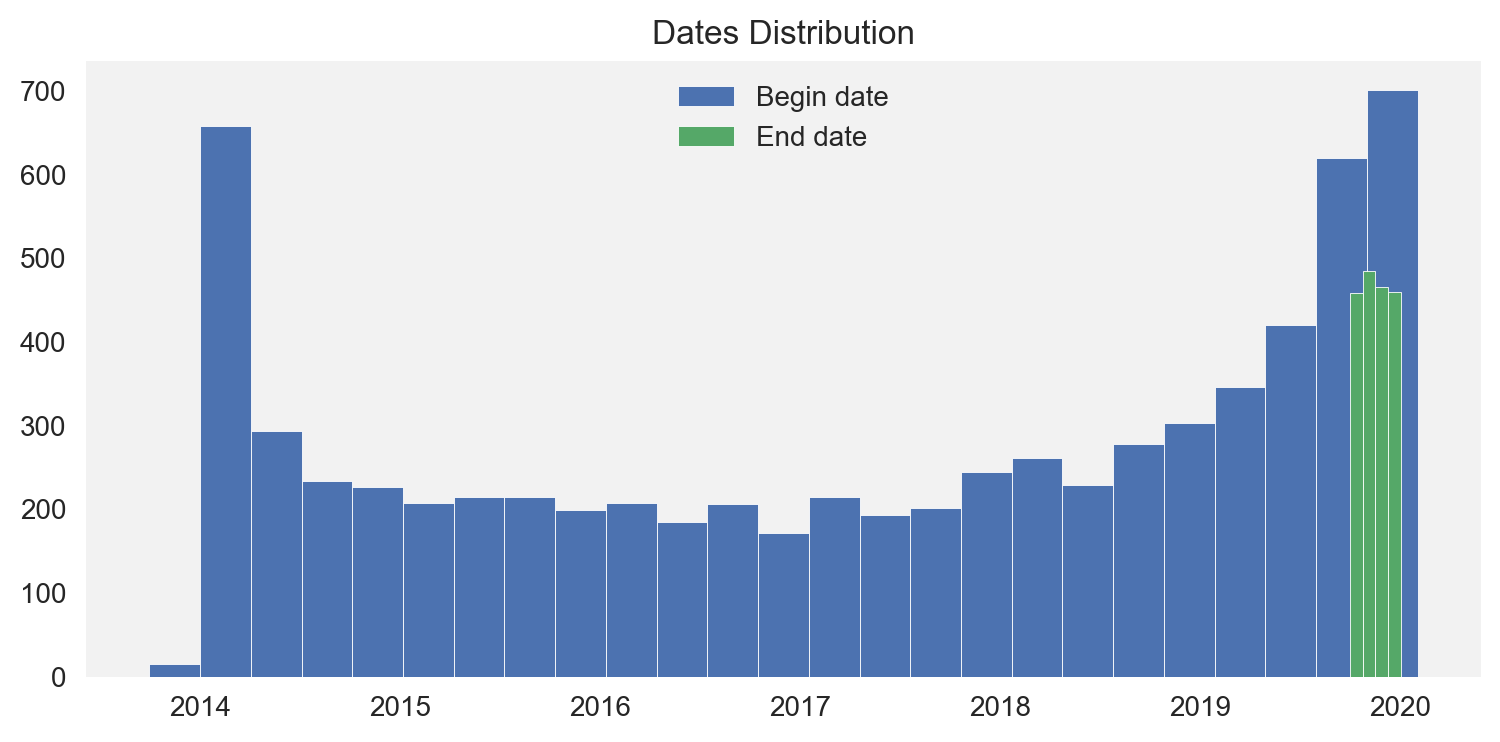

In [31]:
# plot the distribuion of begin dates
plt.hist(data.begin_date, bins=25, label="Begin date")
plt.hist(data.end_date, bins=4, label="End date") # selected 4 bins for 4 months
plt.title("Dates Distribution")
plt.legend()
plt.show()

Customers who terminated their contracts did so during the last 5 months;

### Charges

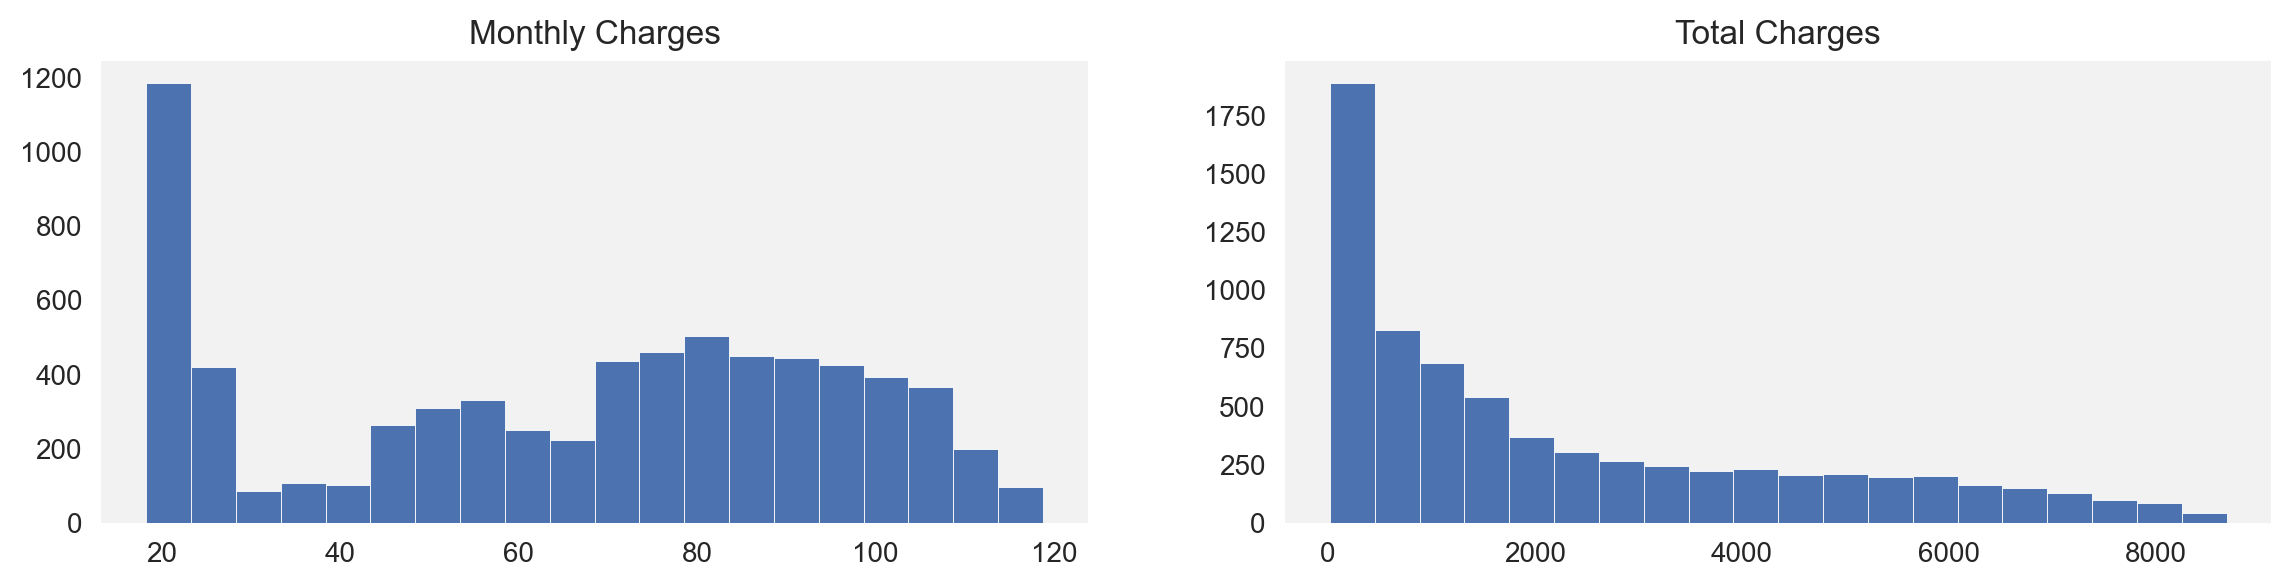

In [32]:
# compare monthly and total charges
plt.figure(figsize=(14,3))

plt.subplot(121)
plt.hist(data["monthly_charges"], bins=20)
plt.title("Monthly Charges")

plt.subplot(122)
plt.hist(data["total_charges"], bins=20)
plt.title("Total Charges");

The `monthly_charges` distribution does not reflect the `total_charges`, apparently because of the difference in contracts duration.

<a id="contract-duration-graph"></a>

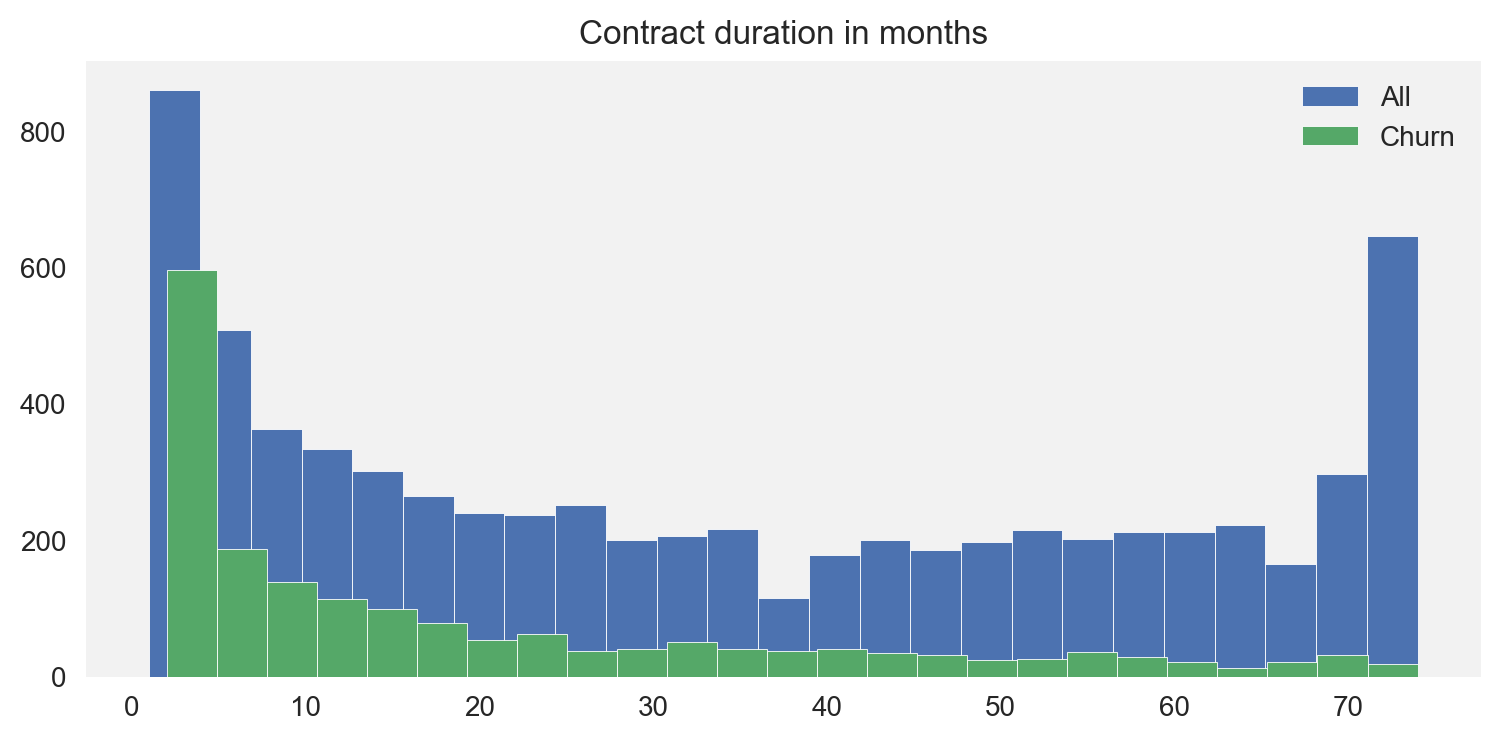

In [33]:
# compare contract duration for churn with all data
data_churn = data[data.churn == 1]

plt.hist(data.contract_duration, bins=25, label="All")
plt.hist(data_churn.contract_duration, bins=25, label="Churn")
plt.legend()
plt.title("Contract duration in months");

Among those who have stopped their service, there are more new customers who signed up during the last half-year than old customers with long-going contracts.

### Categorical columns

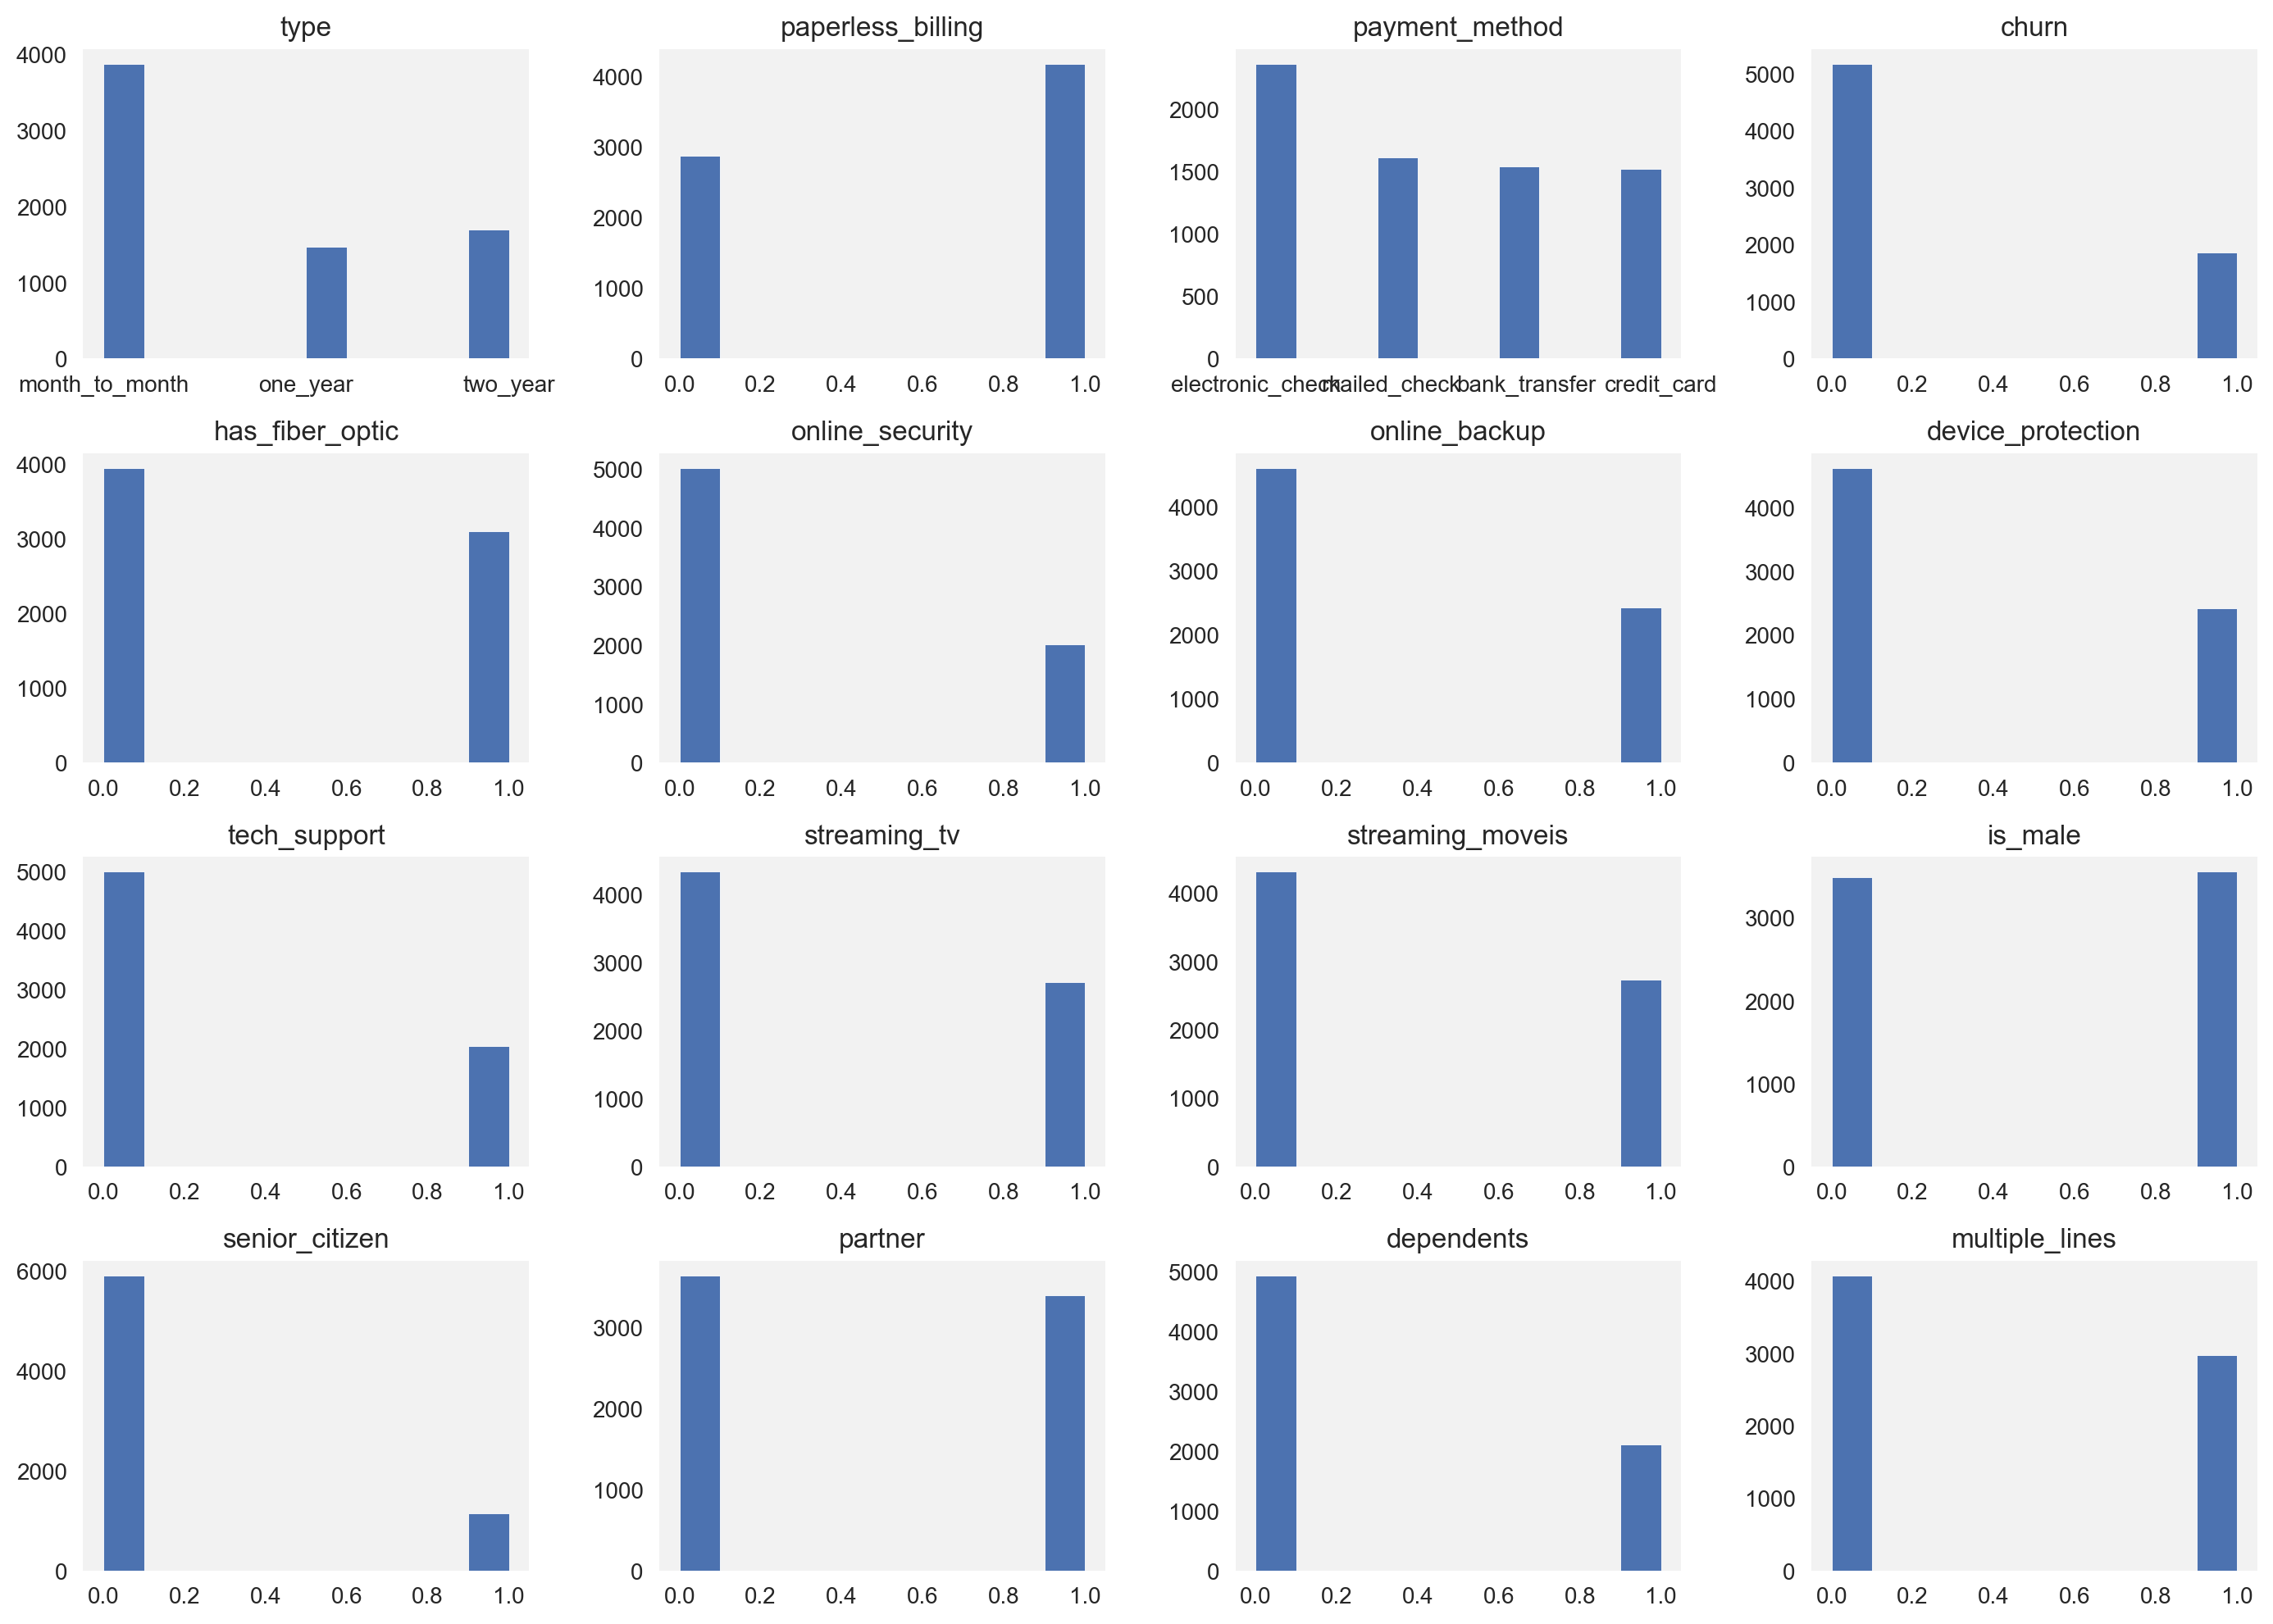

In [34]:
# see how classes for each internet option are balanced 
plt.figure(figsize=(14,10))
col = 0            
cat_cols = data.drop(
    ["customer_id","begin_date","end_date","monthly_charges","total_charges","contract_duration"], 
    axis=1).columns

for column in cat_cols:
    col += 1
    plt.subplot(4, 4, col)
    plt.hist(data[column])
    plt.title(column)
        
plt.tight_layout()

The target class is imbalanced, this should be considered when splitting the data and building the training dataset.
There's not much to notice about the other columns, their values seem to be distributed naturally.

### Correlation
<a id="correlation-matrix"></a>

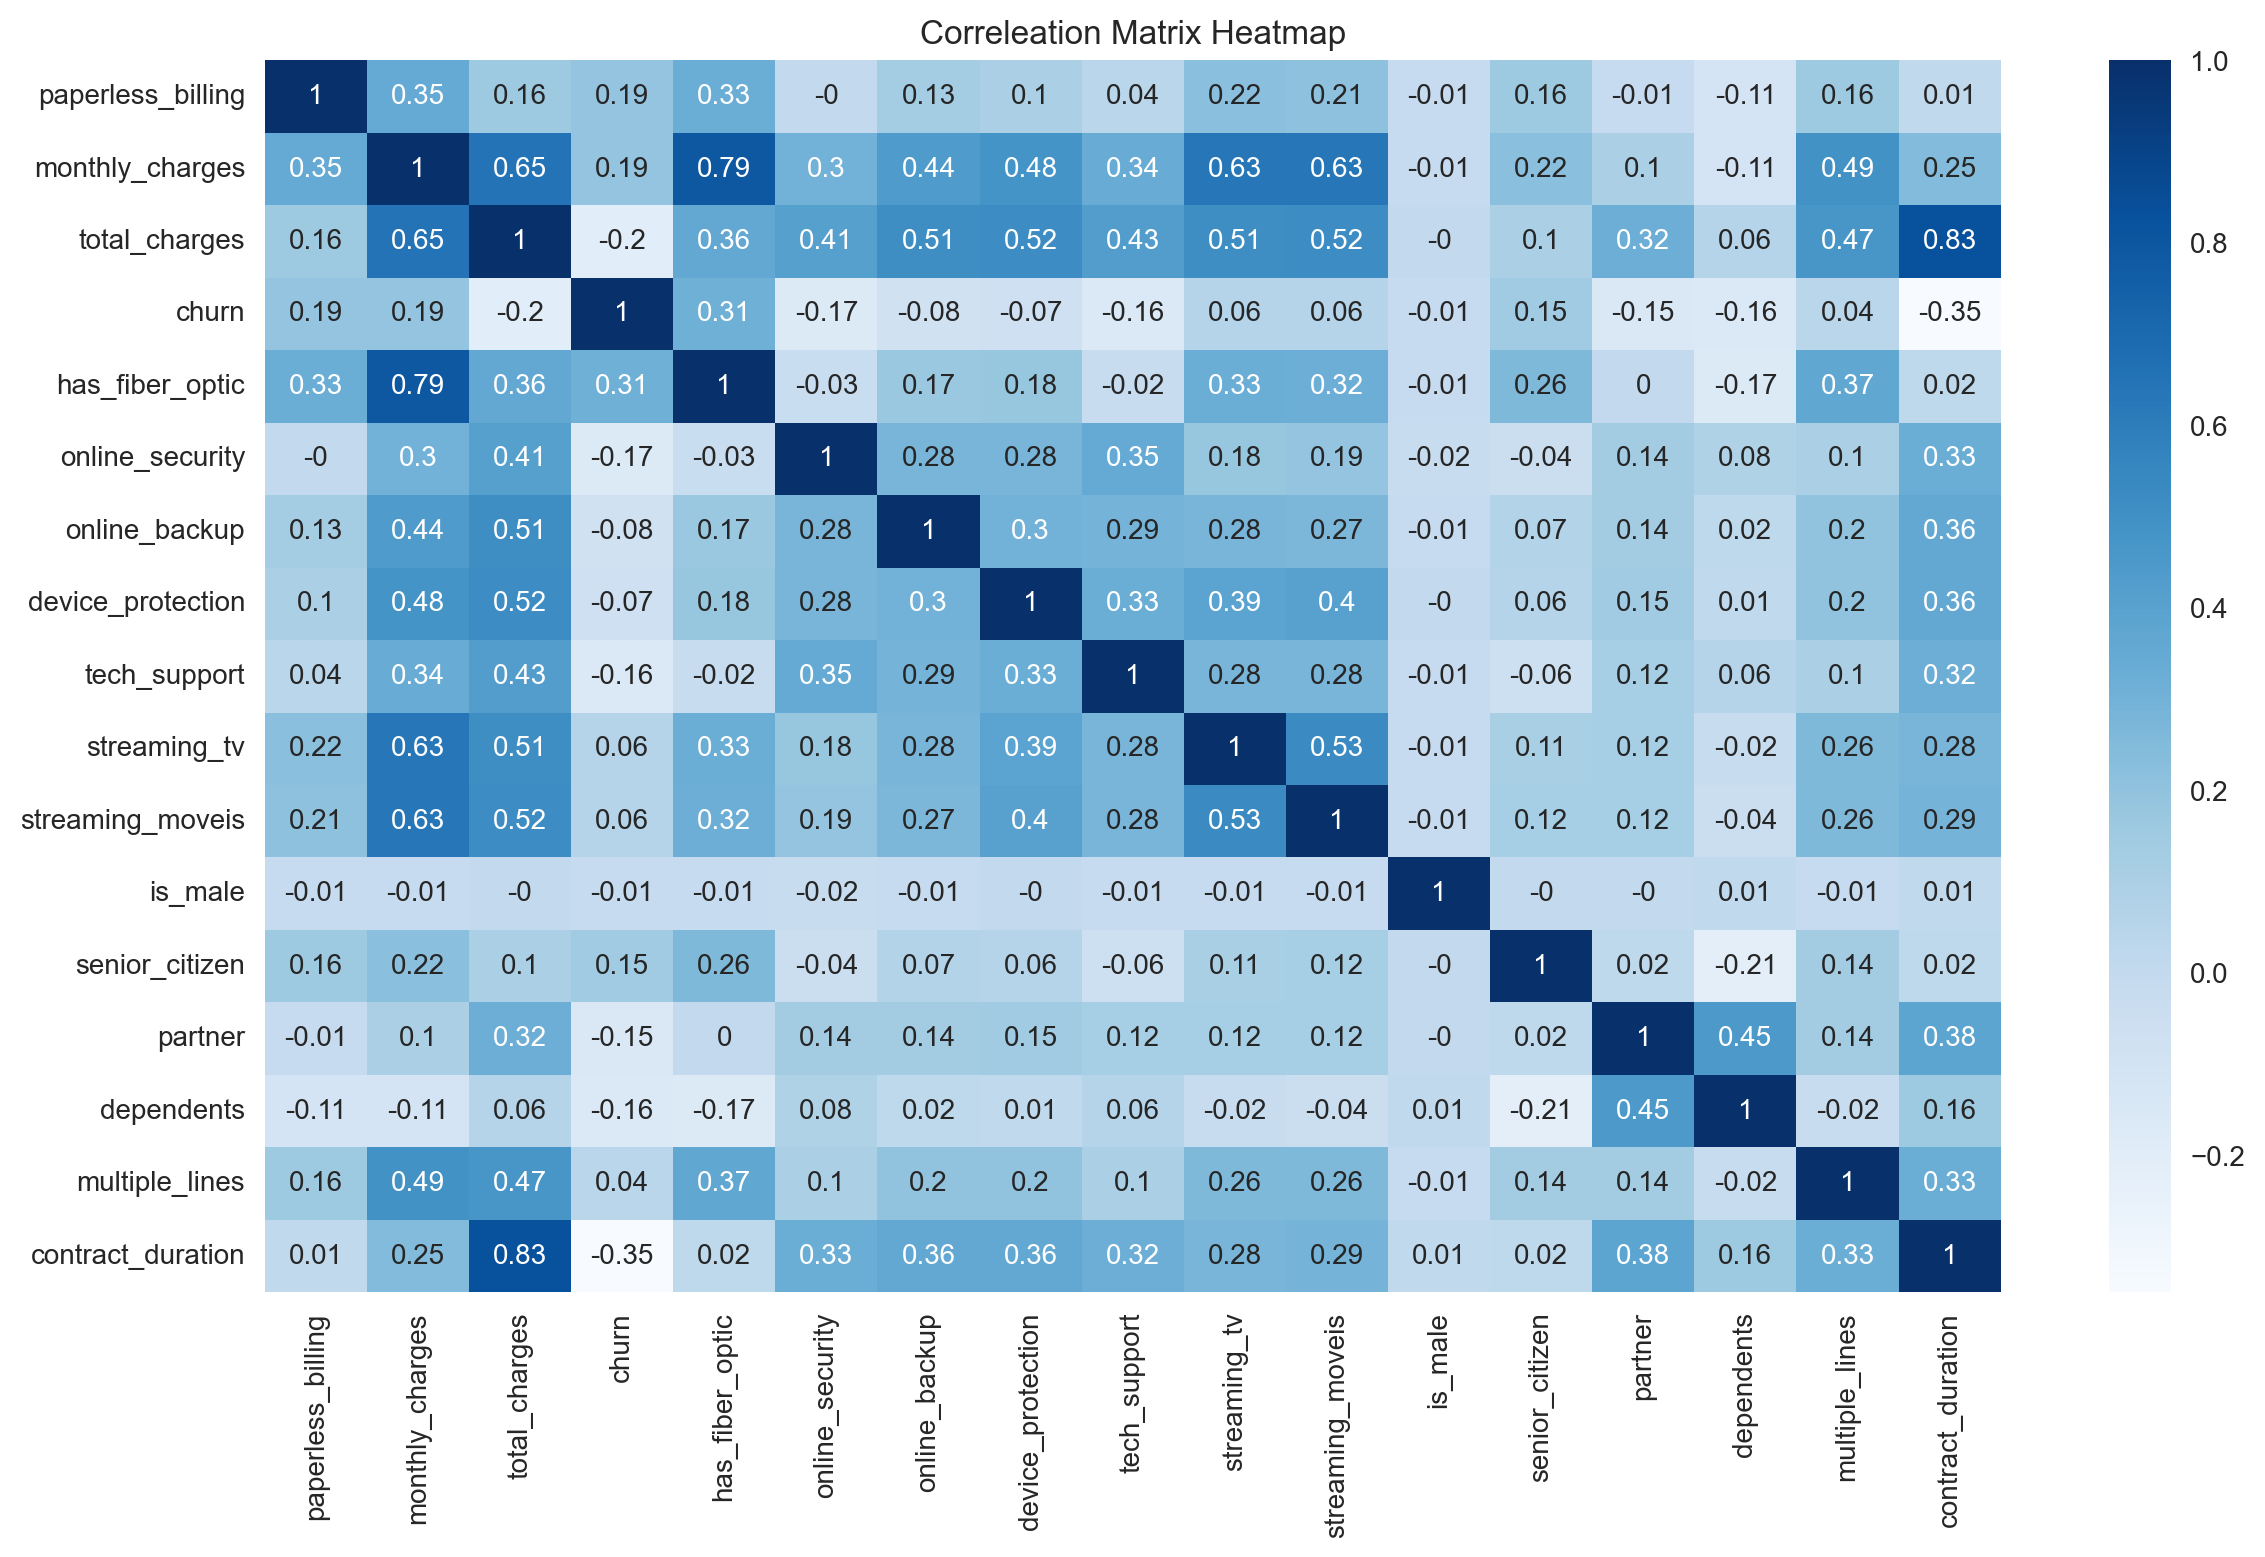

In [35]:
# create a correlation matrix for numerical features
corr_matrix = data.drop(["end_date","begin_date","customer_id","payment_method","type"], axis=1).corr().round(2)

plt.figure(figsize=(14,8))
sns.heatmap(corr_matrix, annot=True, cmap="Blues")
plt.title("Correleation Matrix Heatmap");

- The `total_charges` feature is highly correlated with the `contract_duration`, which is expected. However, the `contract_duration` is somewhat correlated with the target (this tendency can be seen on [the graph](#contract-duration-graph)), while the `total_charges` is correlated less.   
*Since the former is partly represented in the latter, and also considering that the `contract_duration` was derived from the target feature, this column will not be used in training to prevent target leakage.*
- The monthly and total charges, and also the contract duration are correlated with using additional services. 
- The target—`churn`—column has some correlation with the internet service connection type (`has_fiber_optic`). Having this option also seems to significantly affect the monthly charges.

***

## Models training

### Prepare for training

#### Libraries

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

#### Prepare features

In [37]:
# drop excessive columns
X = data.drop(["customer_id","begin_date","end_date","contract_duration", "churn"], axis=1)
y = data["churn"]

# encode the remainging categorical columns
X = pd.get_dummies(X, columns=["payment_method", "type"])

**NOTE:** For encoding, the first column hasn't dropped by intention: to analyze and plot the most impactful features at the end of the project.

In [38]:
# save the random state for further use
state = 65987

# separate the test set
X_, X_test, y_, y_test = train_test_split(X, y, random_state=state, test_size=.1, stratify=y)

# split the rest into the training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=.2, random_state=state, stratify=y_)

# scale the monthly and total charges
scaler = MinMaxScaler()
X_train[["monthly_charges","total_charges"]] = scaler.fit_transform(X_train[["monthly_charges","total_charges"]])
X_valid[["monthly_charges","total_charges"]] = scaler.transform(X_valid[["monthly_charges","total_charges"]])
X_test[["monthly_charges","total_charges"]] = scaler.transform(X_test[["monthly_charges","total_charges"]])

In [39]:
# upsample the training dataset to level out the classes imbalance
upsampler = SMOTE(sampling_strategy="auto", k_neighbors=1, random_state=state)
X_train_up, y_train_up = upsampler.fit_resample(X_train, y_train)

#### Evaluation Procedure

In [40]:
def evaluate_model(model, features, target):
    """
    Takes in a model, features and returns key metrics and graphs.
    """
    # creata a dictionary for storing statistics
    eval_stats = {}
    fig, axs = plt.subplots(1,2, figsize=(9, 4))
    
    pred_target = model.predict(features)
    try:
        pred_proba = model.predict_proba(features)[:,1]
    except:
        pred_proba = model.predict(features)
    
    # accuracy score
    ax = axs[0]
    thresholds = np.arange(0., 1.01,0.1)
    
    accuracies = [accuracy_score(target, pred_proba >= threshold) for threshold in thresholds]
    max_acc_idx = np.argmax(accuracies)
    eval_stats["Accuracy"] = accuracies[max_acc_idx]
    
    ax.plot(thresholds, accuracies, # plot accuracies for different thresholds
            label=f"max={accuracies[max_acc_idx]:.2f} @ {thresholds[max_acc_idx]:.2f}") 
    ax.plot(thresholds[max_acc_idx], accuracies[max_acc_idx], # the threshold for the best accuracy
            color="green", marker="o", markersize=7) 
    
    for threshold in thresholds:  # setting cross marks for some thersholds
        closest_value_idx = np.argmin(np.abs(thresholds-threshold))
        marker_color = "orange" if threshold != 0.5 else "red"
        ax.plot(thresholds[closest_value_idx], accuracies[closest_value_idx], 
                color=marker_color, marker="X", markersize=5)
        
    # setting up axes
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_ylabel("Threshold")
    ax.set_xlabel("Accuracy")
    ax.legend(loc="lower center")
    ax.set_title(f'Acuracy vs Threshold')
    
    # ROC-AUC score
    ax = axs[1]
    fpr, tpr, roc_thresholds = roc_curve(target, pred_proba)
    roc_auc = roc_auc_score(target, pred_proba)
    eval_stats["ROC-AUC"] = roc_auc
    
    ax.plot(fpr, tpr, label=f"ROC-AUC={roc_auc:.2f}")  # plot false positive / true positive curve
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--') # draw the baseline
    
    for threshold in thresholds:  # setting cross marks for some thersholds
        closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
        marker_color = "orange" if threshold != 0.5 else "red"
        ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color,
                marker="X", markersize=5)
        
    # set up axes
    ax.set_xlim([-0.02, 1.02])    
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend(loc='lower center')        
    ax.set_title(f'ROC Curve')
    
    eval_stats = pd.Series(eval_stats).round(2)
    
    return eval_stats

### Scikit-learn models

In [41]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#### Dummy model

Accuracy    0.73
ROC-AUC     0.50
dtype: float64

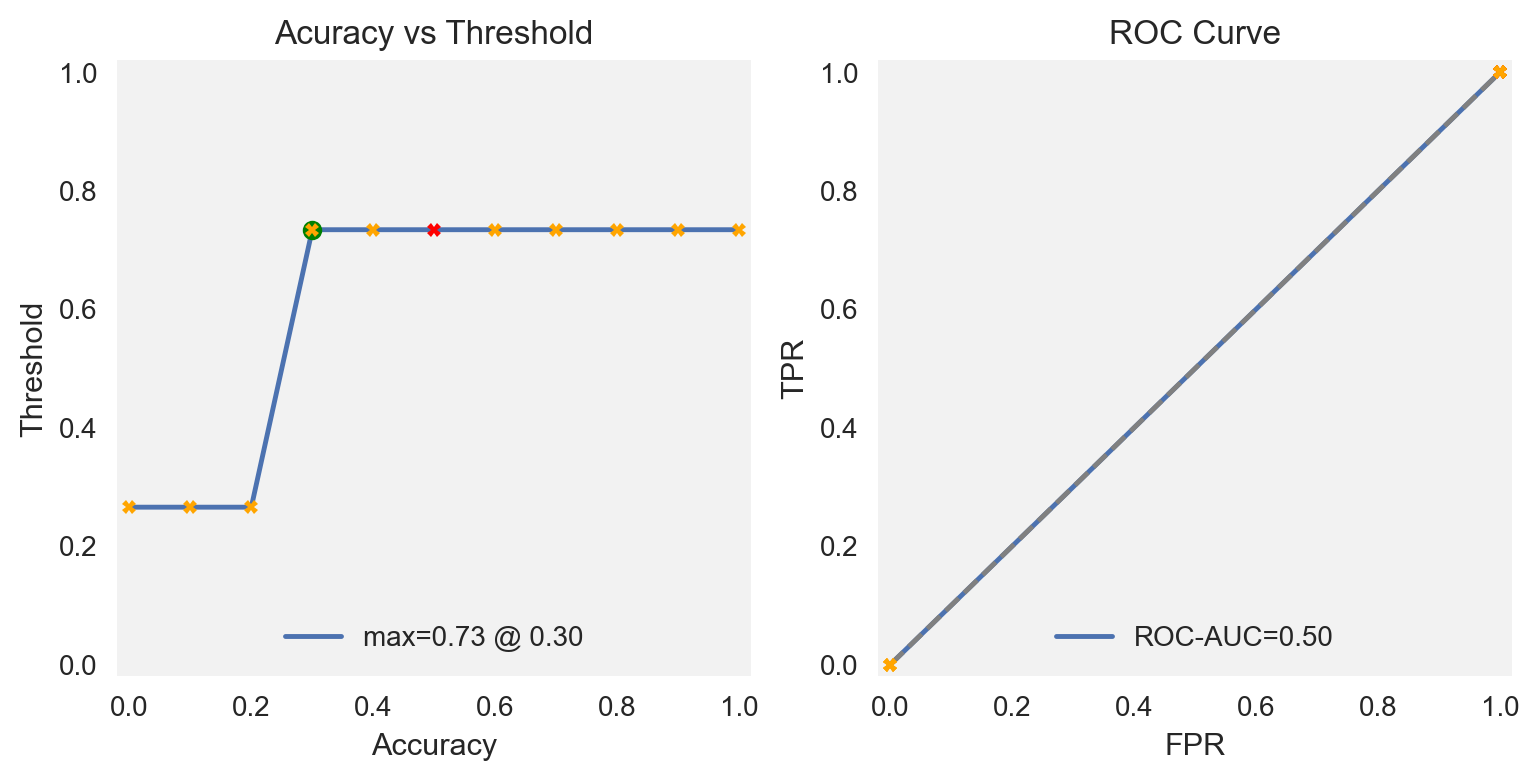

In [42]:
# try the random predictive model as a baseline
dummy_clfr = DummyClassifier(random_state=state).fit(X_train, y_train)
evaluate_model(dummy_clfr, X_valid, y_valid)

#### LogisticRegression

Accuracy    0.80
ROC-AUC     0.83
dtype: float64

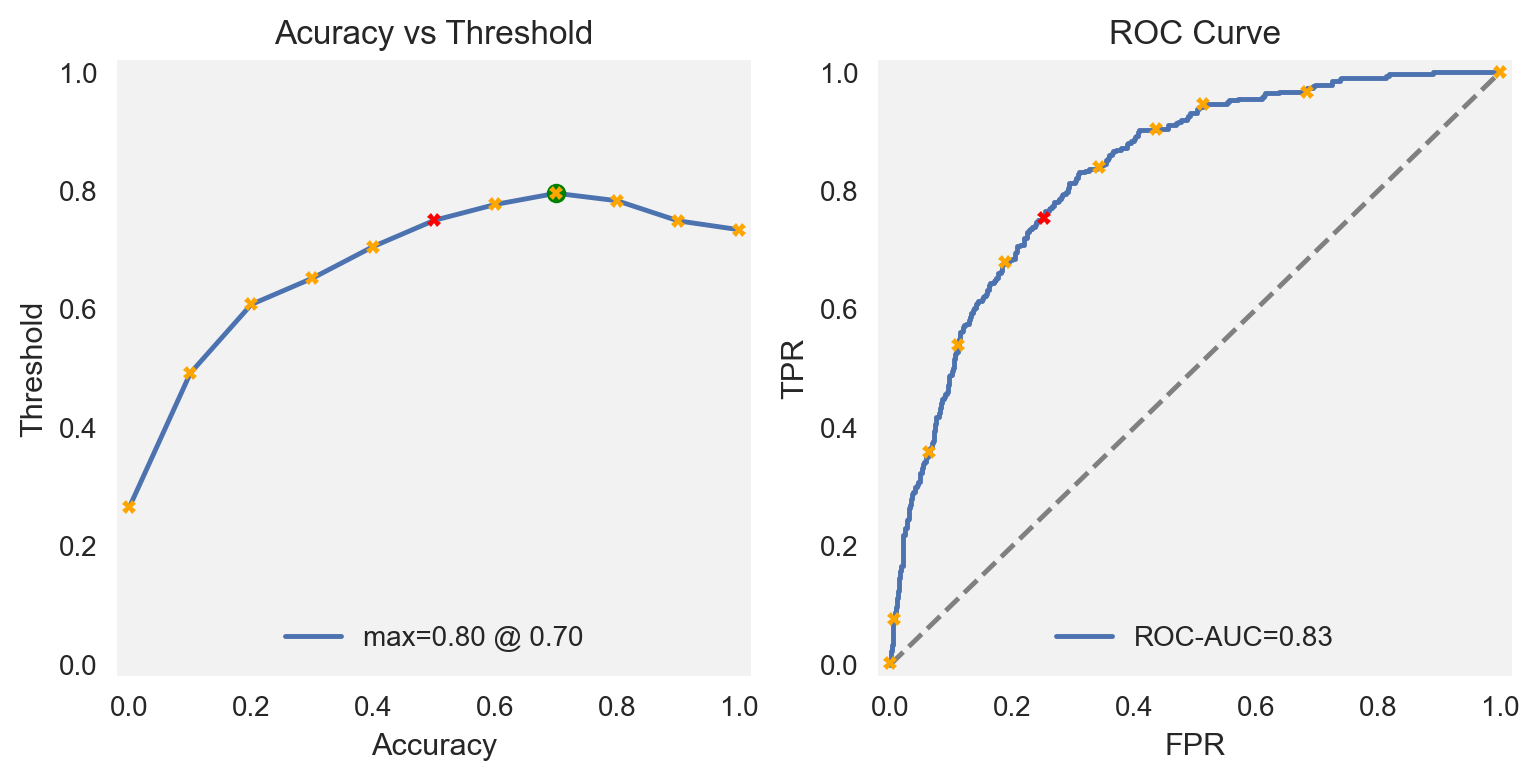

In [43]:
lr = LogisticRegression().fit(X_train_up, y_train_up)
evaluate_model(lr, X_valid, y_valid)

It is unlikely that this model can be improved, but it can serve as a good standard to compare the following models.

#### SupportVectorClassifier

Accuracy    0.79
ROC-AUC     0.81
dtype: float64

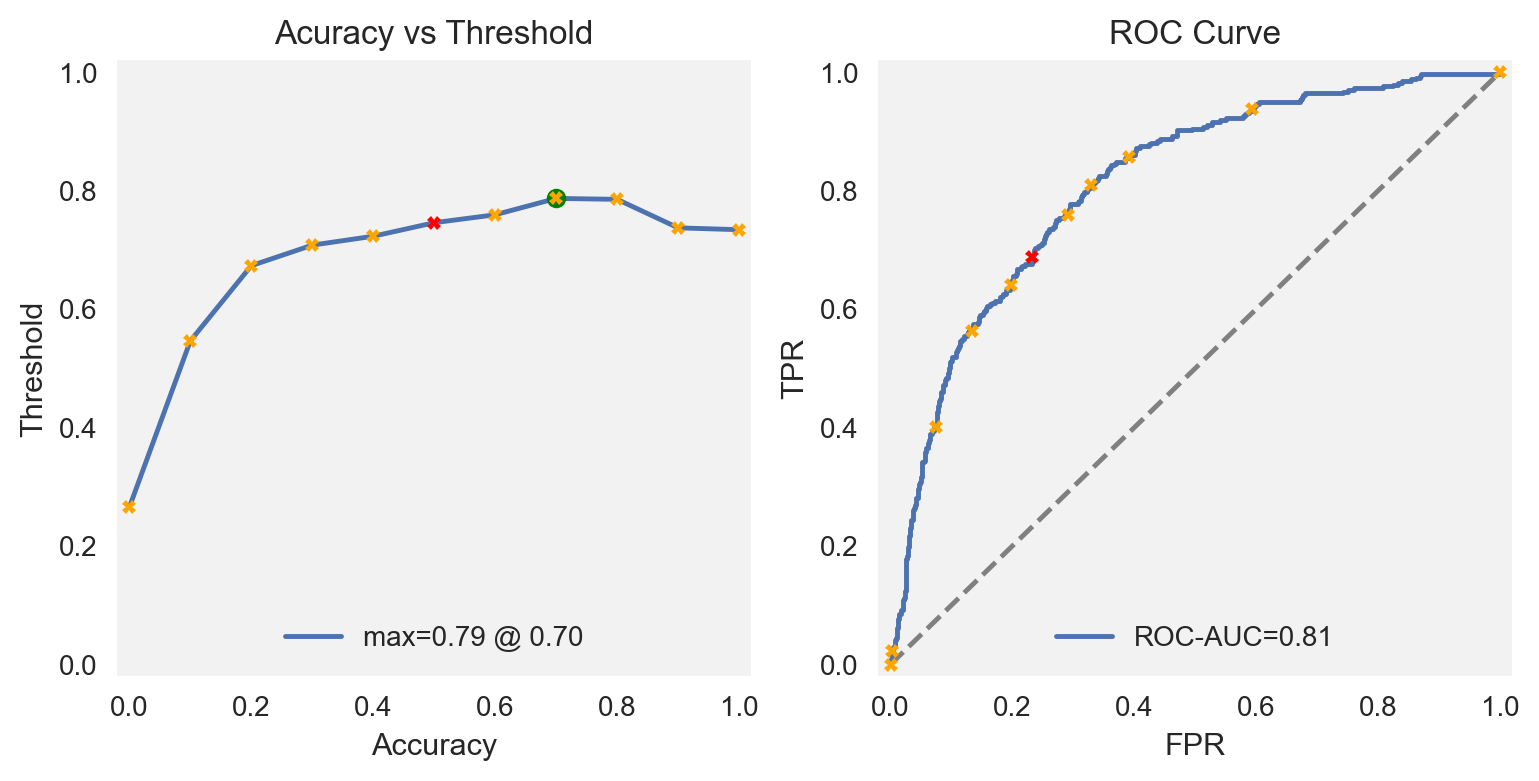

In [44]:
svc = SVC(probability=True).fit(X_train_up, y_train_up)
evaluate_model(svc, X_valid, y_valid)

SVC performs worse than LogisticRegression. It is unlikely to improve here either.

#### RandomForestClassifier

Accuracy    0.78
ROC-AUC     0.81
dtype: float64

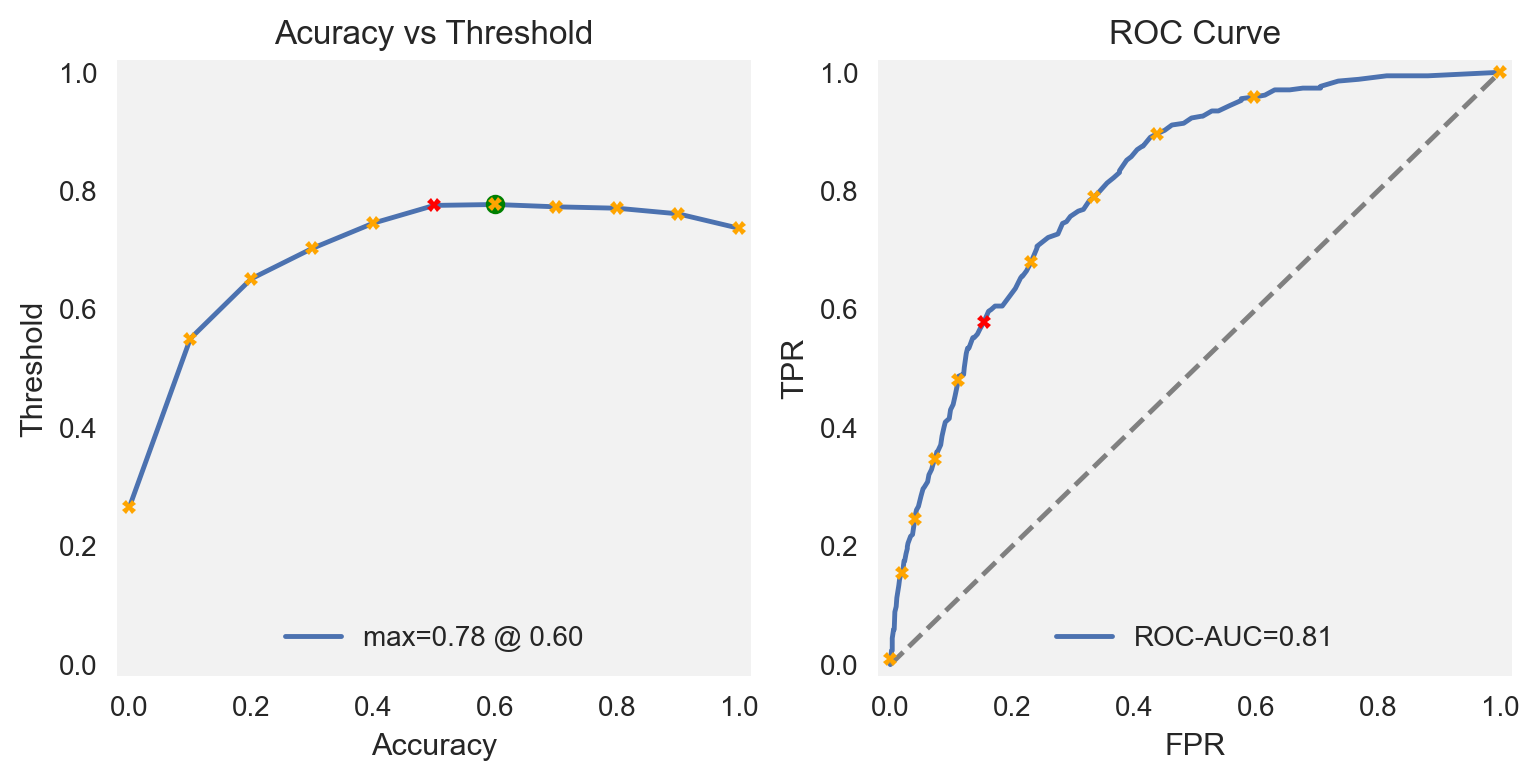

In [45]:
# test a basic model
rf = RandomForestClassifier(random_state=state, n_jobs=-1).fit(X_train_up, y_train_up)
evaluate_model(rf, X_valid, y_valid)

Hyperparameters tuning may improve this model.

In [46]:
# parameters grid
n_estimators = [10, 50, 100, 500, 1000]
max_features = ["sqrt","log2"]
max_depth = range(10, 31, 5)
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

# initialize the upsampler and the model again
smt = SMOTE(sampling_strategy="auto", k_neighbors=1, random_state=state)
rf = RandomForestClassifier(random_state=state, n_jobs=-1)

# build a pipline for upsampling with each fold
imba_pipeline = Pipeline([("smt", smt),
                            ("rf", rf)])

# update parameter names for grid search with pipeline
new_params = {'rf__' + key: param_grid[key] for key in param_grid}
grid_imba = GridSearchCV(estimator=imba_pipeline, param_grid=new_params, n_jobs=-1, cv=5, scoring="roc_auc")
grid_result = grid_imba.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.826216 using {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 1000}


Accuracy    0.80
ROC-AUC     0.84
dtype: float64

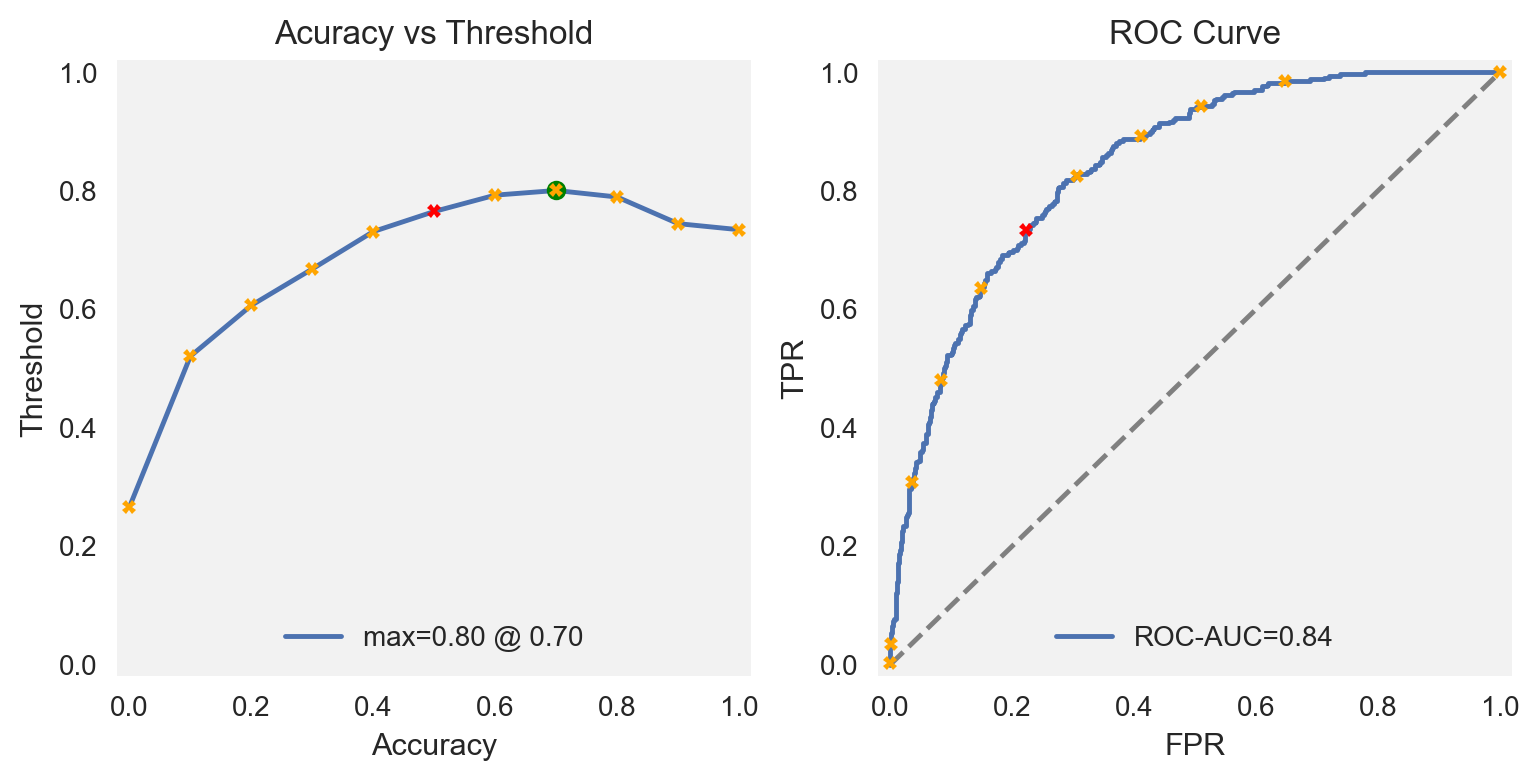

In [47]:
# update model's hyperparameters and evaluate again
rf = RandomForestClassifier(random_state=state, n_jobs=-1,
                           max_depth=10, max_features="sqrt", n_estimators=1000).fit(X_train_up, y_train_up)

evaluate_model(rf, X_valid, y_valid)

The key metric (ROC-AUC score) has improved.

***

### Gradient boosting: CatBoost

In [48]:
from catboost import CatBoostClassifier

Accuracy    0.80
ROC-AUC     0.85
dtype: float64

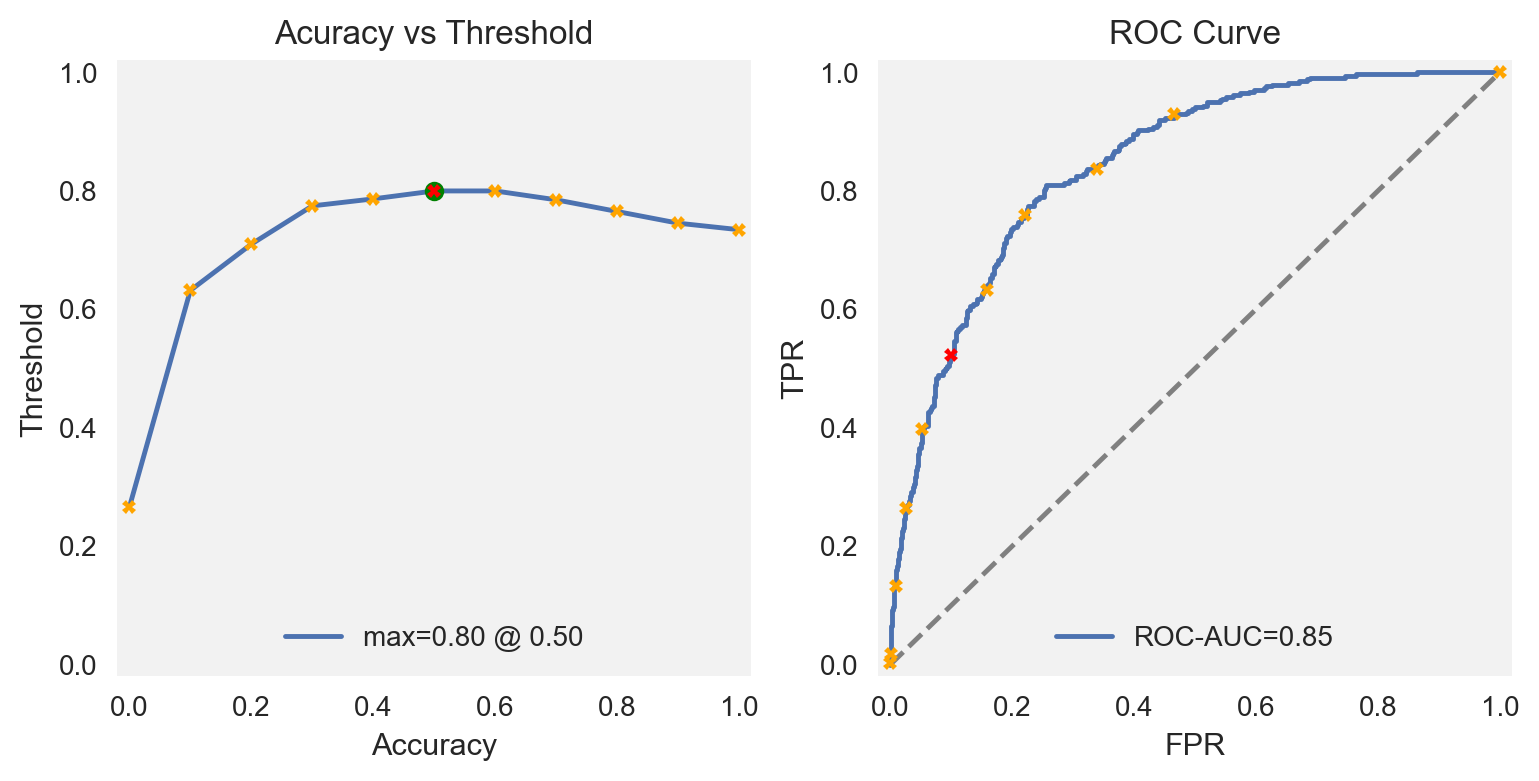

In [49]:
# the basic model
cat = CatBoostClassifier(random_seed=state, verbose=0).fit(X_train, y_train)
evaluate_model(cat, X_valid, y_valid)

Basic CatBoost is better than RandomForest with hyperparameters. Try to find more.

In [ ]:
# the parameters grid
depth = range(2, 6, 1)
eval_metric = ["AUC"]
learning_rate = [.001, .005, .01, .05, .1]
l2_leaf_reg = range(1, 5, 1)

param_grid = dict(depth=depth, eval_metric=eval_metric,
            learning_rate=learning_rate, l2_leaf_reg=l2_leaf_reg)


# initialize the model again
cat = CatBoostClassifier(random_seed=state, verbose=0)

# build a pipline for upsampling with each fold
imba_pipeline = Pipeline([("smt", smt),
                            ("cat", cat)])

# update parameters name for grid search with pipeline
new_params = {'cat__' + key: param_grid[key] for key in param_grid}
grid_imba = GridSearchCV(estimator=imba_pipeline, param_grid=new_params, n_jobs=-1, cv=5, scoring="roc_auc")
grid_result = grid_imba.fit(X_train, y_train)

In [52]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.838579 using {'cat__depth': 2, 'cat__eval_metric': 'AUC', 'cat__l2_leaf_reg': 2, 'cat__learning_rate': 0.01}


Accuracy    0.81
ROC-AUC     0.85
dtype: float64

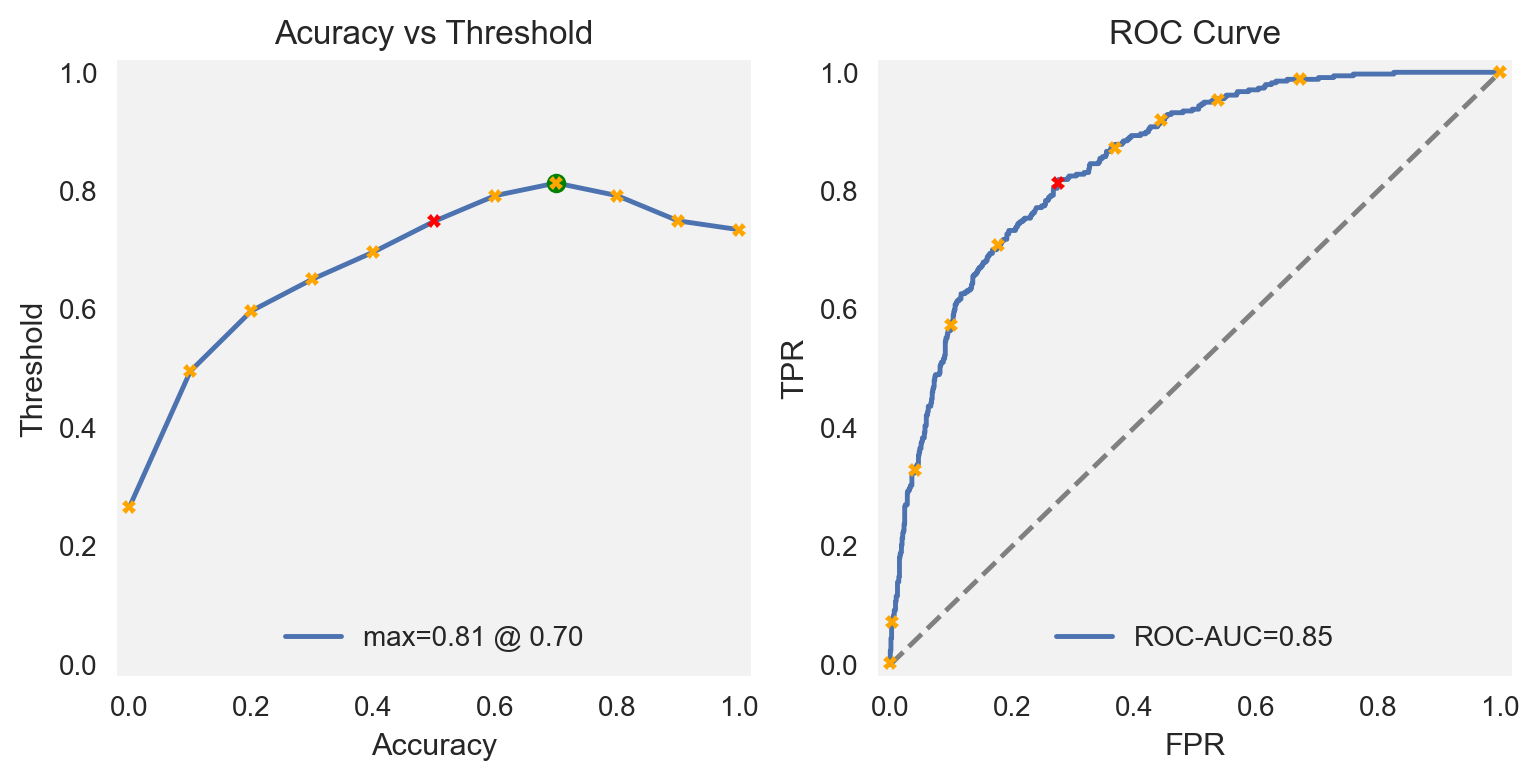

In [53]:
# update the model with the new hyperparameters
cat = CatBoostClassifier(random_seed=state, verbose=0, eval_metric="AUC", l2_leaf_reg=2,
                        depth=2, learning_rate=0.01).fit(X_train_up, y_train_up)

evaluate_model(cat, X_valid, y_valid)

The best model so far.

***

### Tensorflow Keras

**This section has been run separately due to specifics of the tensroflow-compatible conda environment*

In [42]:
# iport packages
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import L1L2, L2, L1, OrthogonalRegularizer

In [47]:
# initialize oprimizer and regularizer
optimizer = Adam(learning_rate=0.001)
regularizer = L1L2(l1=0.001, l2=0.001)

# initialize the model
model = Sequential()

# build the model
model.add(Dense(20, input_dim=X_train_up.shape[1], activation="relu", kernel_regularizer=regularizer))
model.add(Dropout(.1))
model.add(Dense(20, activation="relu", kernel_regularizer=regularizer))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["AUC","accuracy"])

# initialize callbacks
earlystop = EarlyStopping(patience=20)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_auc", 
                                                patience=15, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.000001)
# fit the model
model.fit(
    X_train_up, y_train_up,
    validation_data=(X_valid, y_valid),
    epochs=200, verbose=1,
    callbacks=[earlystop, learning_rate_reduction]
)

Epoch 1/200


2022-12-27 14:22:05.778676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - ETA: 0s - loss: 0.7384 - auc: 0.7641 - accuracy: 0.6992

2022-12-27 14:22:09.048399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 4s 15ms/step - loss: 0.7384 - auc: 0.7641 - accuracy: 0.6992 - val_loss: 0.6702 - val_auc: 0.8176 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 2/200
233/233 [==============================] - 3s 13ms/step - loss: 0.6171 - auc: 0.8270 - accuracy: 0.7533 - val_loss: 0.5939 - val_auc: 0.8227 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 3/200
233/233 [==============================] - 3s 13ms/step - loss: 0.5838 - auc: 0.8339 - accuracy: 0.7565 - val_loss: 0.5944 - val_auc: 0.8264 - val_accuracy: 0.7161 - lr: 0.0010
Epoch 4/200
233/233 [==============================] - 3s 14ms/step - loss: 0.5652 - auc: 0.8385 - accuracy: 0.7584 - val_loss: 0.5862 - val_auc: 0.8281 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 5/200
233/233 [==============================] - 3s 13ms/step - loss: 0.5522 - auc: 0.8427 - accuracy: 0.7632 - val_loss: 0.5709 - val_auc: 0.8294 - val_accuracy: 0.7208 - lr: 0.0010
Epoch 6/200
233/233 [==============================] - 3s 13ms/step

 1/40 [..............................] - ETA: 0s

2022-12-27 14:26:50.095475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 2ms/step


Accuracy    0.80
ROC-AUC     0.84
dtype: float64

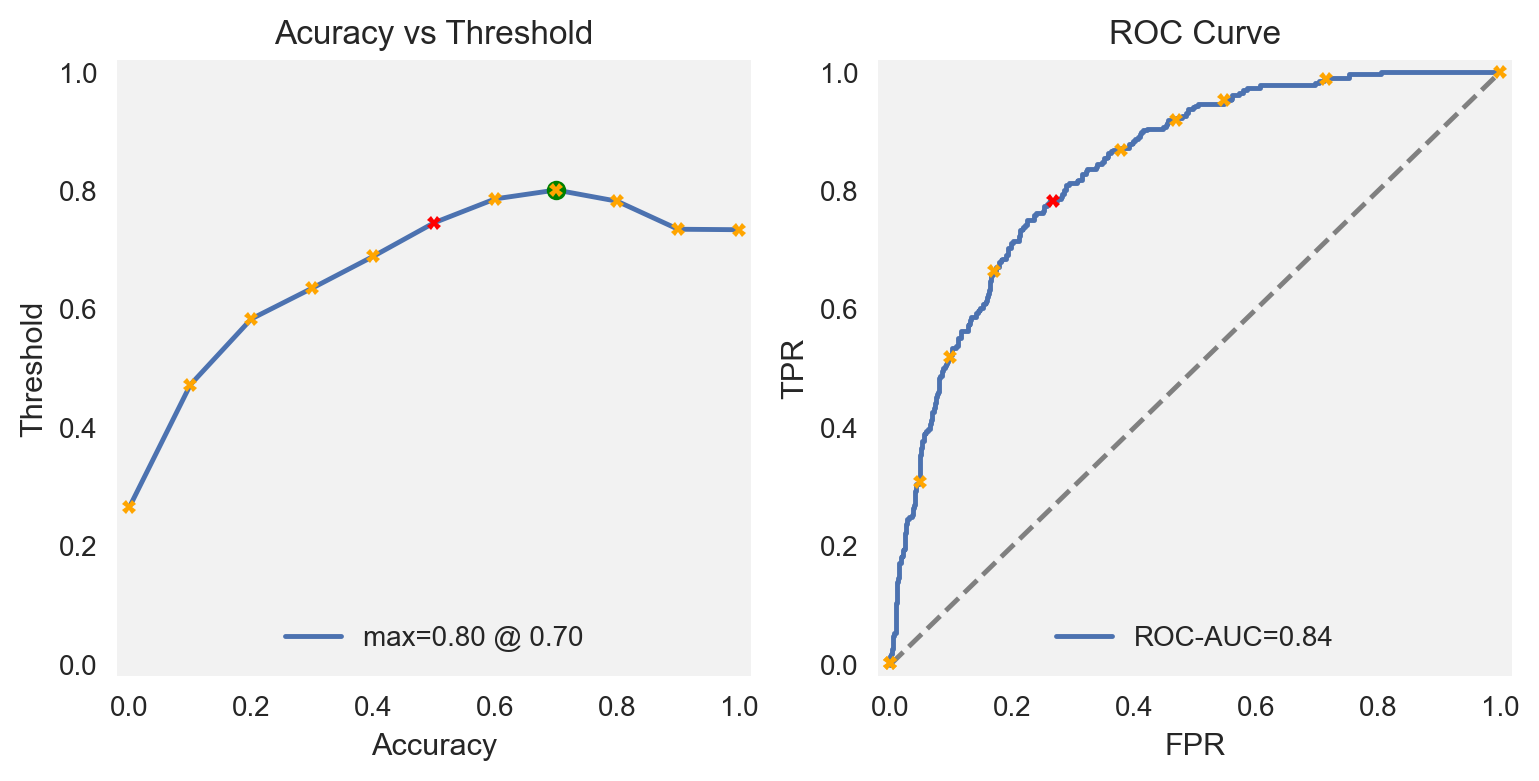

In [48]:
evaluate_model(model, X_valid, y_valid)

## Results Analysis

### Test the best model

Accuracy    0.81
ROC-AUC     0.86
dtype: float64

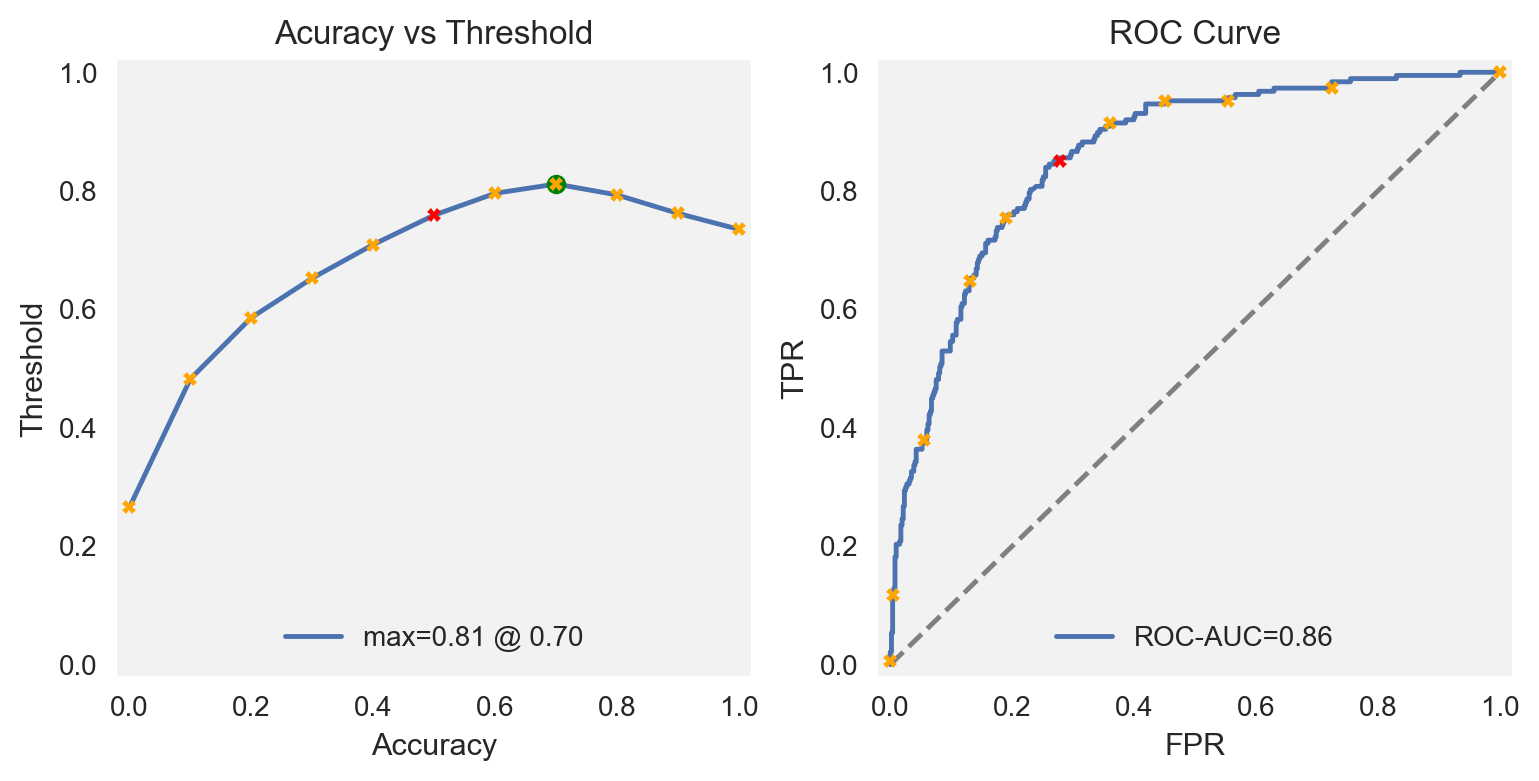

In [54]:
# evaluate the best model on the test set
evaluate_model(cat, X_test, y_test)

### Feature importance

Show how much on average the prediction changes if the feature value changes.

In [55]:
# get feature importance table from the final model
feature_importance = cat.get_feature_importance(prettified=True)
feature_importance.sort_values(by="Importances", inplace=True)

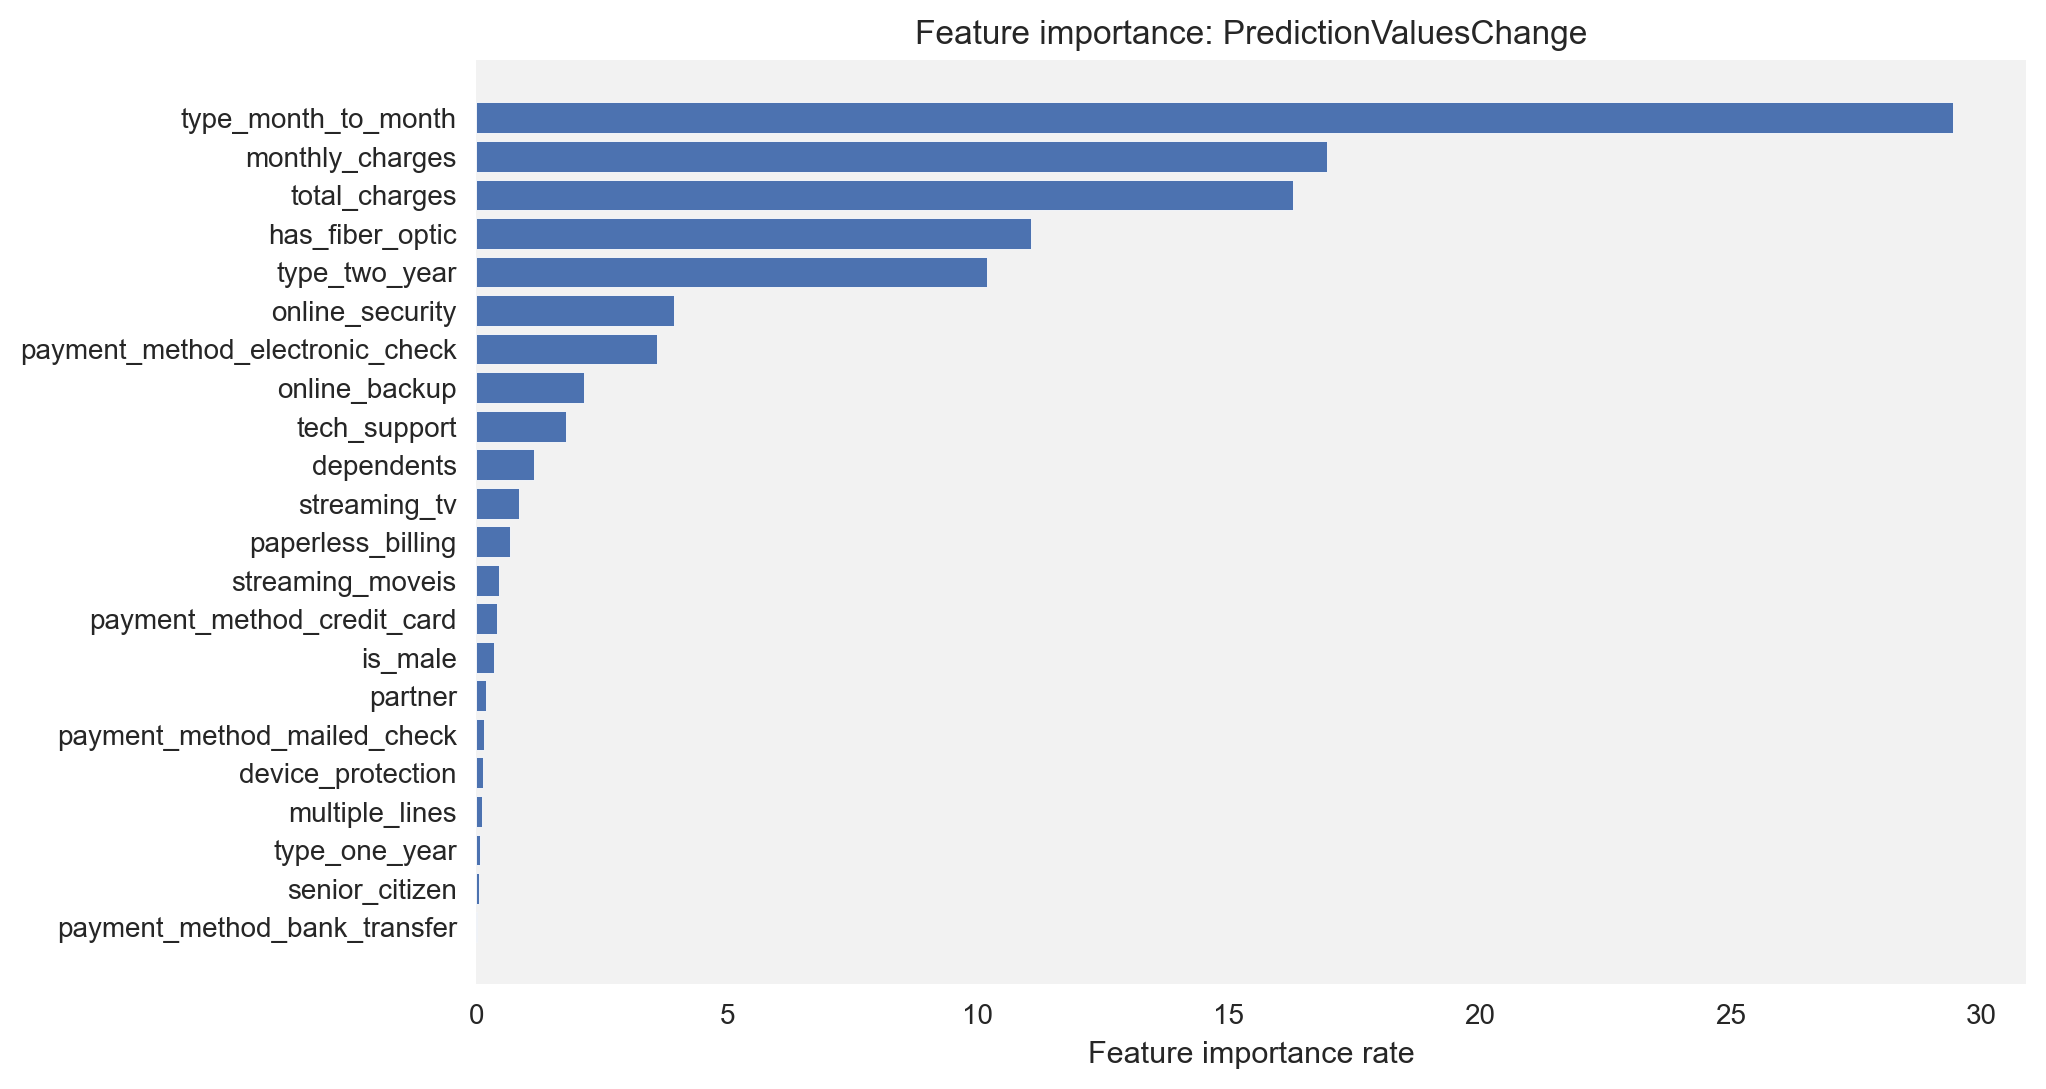

In [56]:
# plot the importance rates
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.iloc[:,0], feature_importance.iloc[:,1])
plt.title("Feature importance: PredictionValuesChange")
plt.xlabel("Feature importance rate");

**The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.*

### Investigate important features

Conduct EDA for the most important features to see what is causing customers to stop their service.

0    5174
1    5174
Name: churn, dtype: int64

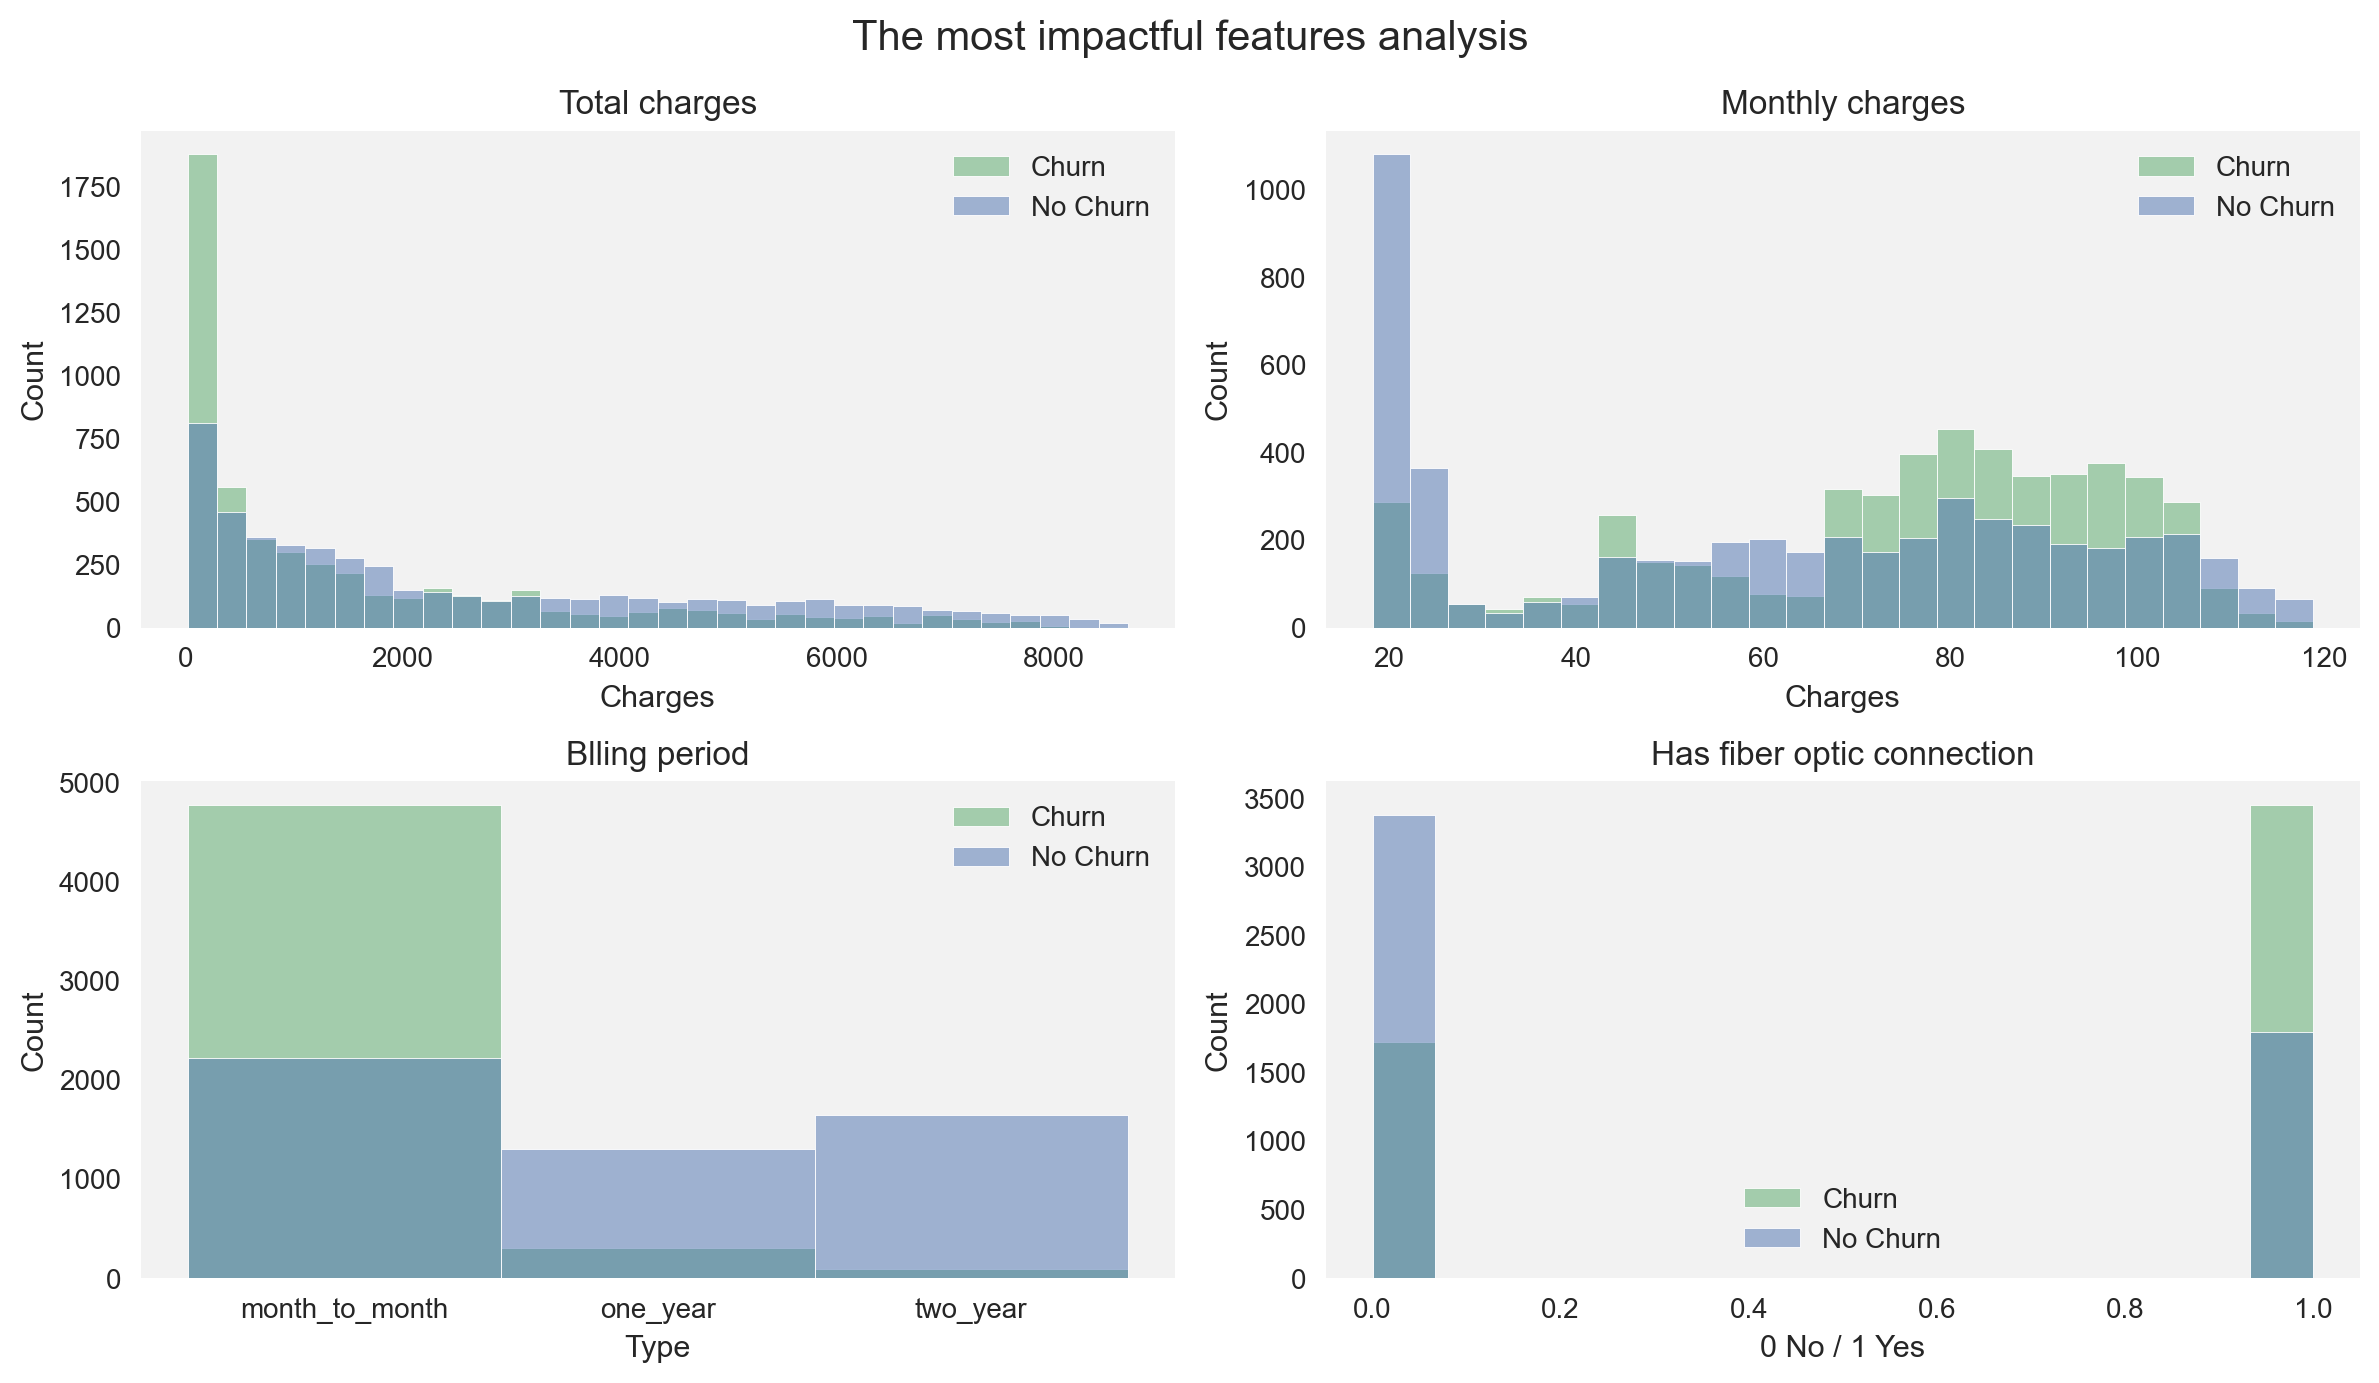

In [57]:
# upsample the data to balance out the differnece in classes
upsampler = SMOTENC(categorical_features=[0,2], random_state=state) # initialize a new upscaler that can handle categorical data
data_upsampled, _ = upsampler.fit_resample(data.iloc[:, 3:], data.churn) # drop up to the third column simce it contains NaNs

fig, axs = plt.subplots(2, 2, figsize=(12, 7))
fig.suptitle("The most impactful features analysis", fontsize=15)

ax=axs[0][0]
sns.histplot(data_upsampled, x="total_charges", hue="churn", ax=ax)
ax.set_title("Total charges")
ax.set_xlabel("Charges")
ax.legend(["Churn","No Churn"])

ax=axs[0][1]
sns.histplot(data_upsampled, x="monthly_charges", hue="churn", ax=ax)
ax.set_title("Monthly charges")
ax.set_xlabel("Charges")
ax.legend(["Churn","No Churn"])

ax=axs[1][0]
sns.histplot(data_upsampled, x="type", hue="churn", ax=ax)
ax.set_title("Blling period")
ax.set_xlabel("Type")
ax.legend(["Churn","No Churn"])

ax=axs[1][1]
sns.histplot(data_upsampled, x="has_fiber_optic", hue="churn", ax=ax)
ax.set_title("Has fiber optic connection")
ax.set_xlabel("0 No / 1 Yes")
ax.legend(["Churn","No Churn"])

fig.tight_layout()
# print the new class balance to keep in mind while exploring the graphs.
data_upsampled.churn.value_counts()

The conclusions that can be derived from the graphs are:
1. The customers who stop their service tend to have the lowest total charges, which tells us that often it's new customers.  
\*also see the [contract duration graph](#contract-duration-graph).
2. Those who stopped their service in general have greater monthly charges.  
This feature is also highly correlated with having fiber optic connection type, see the [correlation matrix](#correlation-matrix)
3. Churned customers are mostly billed month-to-month.
4. Churned customers are more likely to have fiber optic connection.

***

## Solution Report

#### Work Steps

While working on this project, the following steps wore taken: 
1. Before taking on the task, a quick data exploration was made with the help of the pandas profiling library.
2. After clarifying the task and the data description, the data was preprocessed: missing values were filled in, correct data types were assigned, the data was encoded and merged into one dataframe.
3. The EDA gave some insights about the data, like class imbalance. A few features were discovered to be strongly correlated.
4. Further steps before model training: features scaling and encoding, data splitting, and building an evaluation procedure.
5. Several models were trained, and the gradient boosting algorithm showed to be the best solution for this problem.
6. The model's feature importance calculation was analyzed and, with the help of quick EDA, some hypotheses on a typical churned customer were suggested.

#### Difficulties

- Due to the target class imbalance, the training dataset had be upsampled. But the GridSearch doesn't work well with datasets that have been upsampled. To get proper results, the data needs to be upsampled for each fold separately. This was done with the help of the scikit-learn pipeline class.
- Depending on the initial random state value, the model's performance could significantly vary. Such a random state value was chosen, which would result in fairly average scoring.

#### Key steps and model quality

Crucial steps for solving this task were preventing target leakage by dropping the date columns from the model's features and conducting a data oversampling to level-out class imbalance when training the model.

The CatBoost gradient boosting algorithm handled this dataset the best among the models tried. However, the resulting score wasn't consistent with different input parameters, so it would fair to estimate the model's ROC-AUC score at 0.84-0.85 and accuracy at 0.8.